# **FINAL PROJECT STAGE 2**
**DATA SCIENCE BATCH 53 - DATA MARK**

*   M. Haris Maulana Koliq .A
*   Khamsah Akbar
*   Ramadhian Ekaputra


# Employee Churn Analysis and Prediction

### Tujuan Proyek

Proyek ini bertujuan untuk menganalisis faktor-faktor yang memengaruhi churn (perpindahan atau keluar dari perusahaan) karyawan dan membangun model prediktif untuk mengidentifikasi karyawan yang berisiko churn.


### Tahapan Proyek


**A. Baseline Model & Experiments**

1. Baseline model dikembangkan dan dijadikan pembanding untuk model lainnya.
2. Eksperimen dilakukan dengan mencoba berbagai algoritma atau parameter.
3. Model pipeline terdokumentasi dengan baik (notebook atau version control).

**B. Hyperparameter Tuning**

1. Model diuji dengan berbagai hyperparameter untuk meningkatkan performa.
2. Metode cross-validation diterapkan dengan benar.
3. Dokumentasi tuning dan hasil eksperimen jelas dan sistematis.

**C. Model Pipeline Documentation**

1. Pipeline model terdokumentasi dengan baik dan dapat direproduksi.
2. Version control diterapkan dengan baik (contoh: Git, MLflow).
3. Justifikasi pemilihan model dan metode tuning dijelaskan secara detail.



In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import numpy as np
import gc
import xgboost as xgb
import lightgbm as lgb
import catboost as cb 
import seaborn as sns
import math
import pickle
import os

from scipy.spatial.distance import mahalanobis
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import randint as sp_randint
from scipy.stats import chi2, boxcox
from sklearn.model_selection import KFold, StratifiedKFold
from prettytable import PrettyTable
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve,auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import fbeta_score
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier,
    RidgeClassifier
)
from collections import Counter
from scipy.sparse import hstack
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from datetime import datetime
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Load Data

In [8]:
df = pd.read_csv('employee_churn_prediction_updated.csv')

In [9]:
df.tail(5)

,employee_id,age,gender,education,experience_years,monthly_target,target_achievement,working_hours_per_week,overtime_hours_per_week,salary,commission_rate,job_satisfaction,work_location,manager_support_score,company_tenure_years,churn,marital_status,distance_to_office_km,churn_period
995,996,35,Male,Diploma,7,190,1.07,42,19,6845979,0.05,2,Urban,4,3.4,0,Single,16,Stayed
996,997,42,Male,Bachelor,7,92,0.66,55,17,5694991,0.02,4,Rural,3,4.1,1,Single,29,1 Month
997,998,32,Female,Bachelor,7,127,1.11,61,10,4797555,0.04,1,Suburban,4,0.6,1,Single,32,Onboarding
998,999,30,Male,High School,7,77,0.53,54,9,3053010,0.08,2,Suburban,1,1.3,0,Single,19,Stayed
999,1000,23,Male,Bachelor,6,195,0.54,67,3,3907272,0.09,3,Suburban,2,4.5,1,Single,35,Onboarding


# Exploratory Data Analysis (EDA)

## General Info

In [12]:
# Dimensi dan info
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              1000 non-null   int64  
 1   age                      1000 non-null   int64  
 2   gender                   1000 non-null   object 
 3   education                1000 non-null   object 
 4   experience_years         1000 non-null   int64  
 5   monthly_target           1000 non-null   int64  
 6   target_achievement       1000 non-null   float64
 7   working_hours_per_week   1000 non-null   int64  
 8   overtime_hours_per_week  1000 non-null   int64  
 9   salary                   1000 non-null   int64  
 10  commission_rate          1000 non-null   float64
 11  job_satisfaction         1000 non-null   int64  
 12  work_location            1000 non-null   object 
 13  manager_support_score    1000 non-null   int64  
 14  company_tenure_years     

((1000, 19), None)

- Total Baris: 1000
- Total Kolom: 19
- Tidak Ada Missing Values (Semua kolom memiliki 1000 nilai non-null)
- Tidak perlu dilakukan imputasi

Jenis Data:
- Numerik: age, experience_years, monthly_target, target_achievement, working_hours_per_week, overtime_hours_per_week, salary, commission_rate, job_satisfaction, manager_support_score, company_tenure_years, distance_to_office_km

- Kategori: gender, education, work_location, marital_status, churn_period

- Biner: churn (0 = Tidak Berhenti, 1 = Berhenti)

## Statistik Deskriptif

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
employee_id,1000.0,5.005000e+02,2.888194e+02,1.00,250.75,500.50,750.25,1000.0
age,1000.0,3.284500e+01,6.854046e+00,22.00,27.00,33.00,39.00,44.0
experience_years,1000.0,4.495000e+00,2.890732e+00,0.00,2.00,5.00,7.00,9.0
monthly_target,1000.0,1.258770e+02,4.389575e+01,50.00,86.75,127.50,164.00,199.0
target_achievement,1000.0,7.918800e-01,2.287199e-01,0.40,0.59,0.79,0.99,1.2
working_hours_per_week,1000.0,5.410200e+01,8.721907e+00,40.00,46.00,54.00,62.00,69.0
overtime_hours_per_week,1000.0,9.508000e+00,5.739066e+00,0.00,5.00,9.50,15.00,19.0
salary,1000.0,5.487914e+06,1.436482e+06,3000037.00,4258969.50,5471270.00,6727894.00,7999712.0
commission_rate,1000.0,5.883000e-02,2.327817e-02,0.02,0.04,0.06,0.08,0.1
job_satisfaction,1000.0,2.524000e+00,1.125474e+00,1.00,2.00,3.00,4.00,4.0


- Usia Karyawan (age):
Rentang: 22–44 tahun
Rata-rata: ~32,8 tahun
- Pengalaman Kerja (experience_years):
Rata-rata: ~4,5 tahun
Maksimum: 9 tahun
- Target Bulanan (monthly_target):
Rata-rata: ~126 (unit/kinerja)
Maksimum: 199
- Tingkat Pencapaian Target (target_achievement):
Rata-rata pencapaian: ~79%
Maksimum pencapaian: 120%
- Jam Kerja Mingguan (working_hours_per_week):
Rata-rata: ~54 jam/minggu
Maksimum: 69 jam/minggu
- Gaji Karyawan (salary):
Rata-rata: ~5,49 juta
Rentang: ~3 juta hingga ~8 juta rupiah
- Job Satisfaction & Manager Support:
Skala: 1–4
Rata-rata: ~2,5 (sedang)
- Jarak ke Kantor (distance_to_office_km):
Rata-rata: ~24 km
Rentang: 1–49 km
- Churn Rate (churn):
Rata-rata churn: ~62,9% dari total karyawan.


In [17]:
df.describe(include='object')

,gender,education,work_location,marital_status,churn_period
count,1000,1000,1000,1000,1000
unique,2,3,3,2,4
top,Male,Diploma,Urban,Single,Stayed
freq,703,404,500,606,371


- **Gender**: Mayoritas **laki-laki (703 dari 1000)**
- **Tingkat Pendidikan**: Mayoritas **Diploma (404 dari 1000)**
- **Lokasi Kerja**: Setengah karyawan berada di **Urban (500 dari 1000)**
- **Status Pernikahan**: Mayoritas **Single (606 dari 1000)**
- **Churn Period**: Paling banyak **Stayed (371 dari 1000)**

## Dataset Visualization

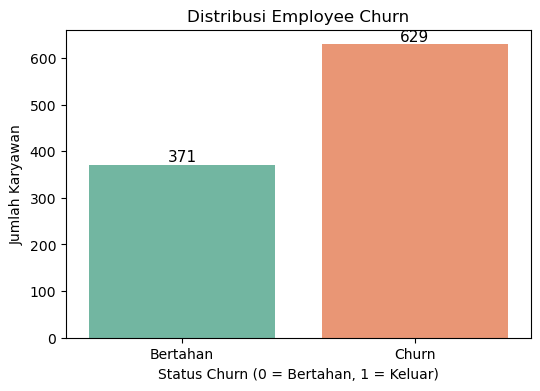

In [20]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='churn', data=df, palette='Set2')
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=11)
plt.title("Distribusi Employee Churn")
plt.xlabel("Status Churn (0 = Bertahan, 1 = Keluar)")
plt.ylabel("Jumlah Karyawan")
plt.xticks([0, 1], ['Bertahan', 'Churn'])
plt.show()

### Distribusi Churn

Visualisasi di atas menunjukkan distribusi target variabel `churn`:

- **0 (Tidak churn):** 371 karyawan  
- **1 (Churn):** 629 karyawan  


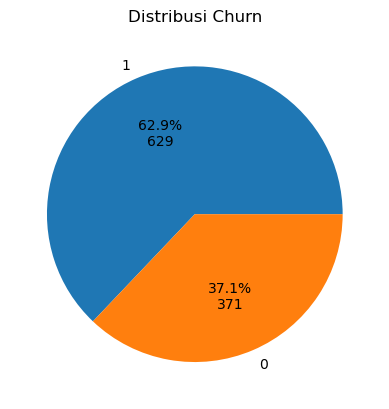

In [22]:
# Churn Pie Chart
def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, df['churn'].value_counts().values.sum()*x/100)

plt.pie(df['churn'].value_counts().values, labels=df['churn'].value_counts().index, autopct=fmt)
plt.title("Distribusi Churn")
plt.show()

### 📊 Distribusi Churn (Pie Chart)

Sebanyak **62.9%** dari total **1000 karyawan** di perusahaan terindikasi mengalami **churn** (keluar dari perusahaan), sedangkan **37.1%** tetap bertahan.

### 📌 Insight:
- Angka churn yang tinggi menunjukkan adanya masalah serius dalam **retensi karyawan**.


Sebanyak 62.9% dari total 1000 karyawan churn di perusahaan yang harus dianalisis lebih lanjut mengapa hal ini dapat terjadi.

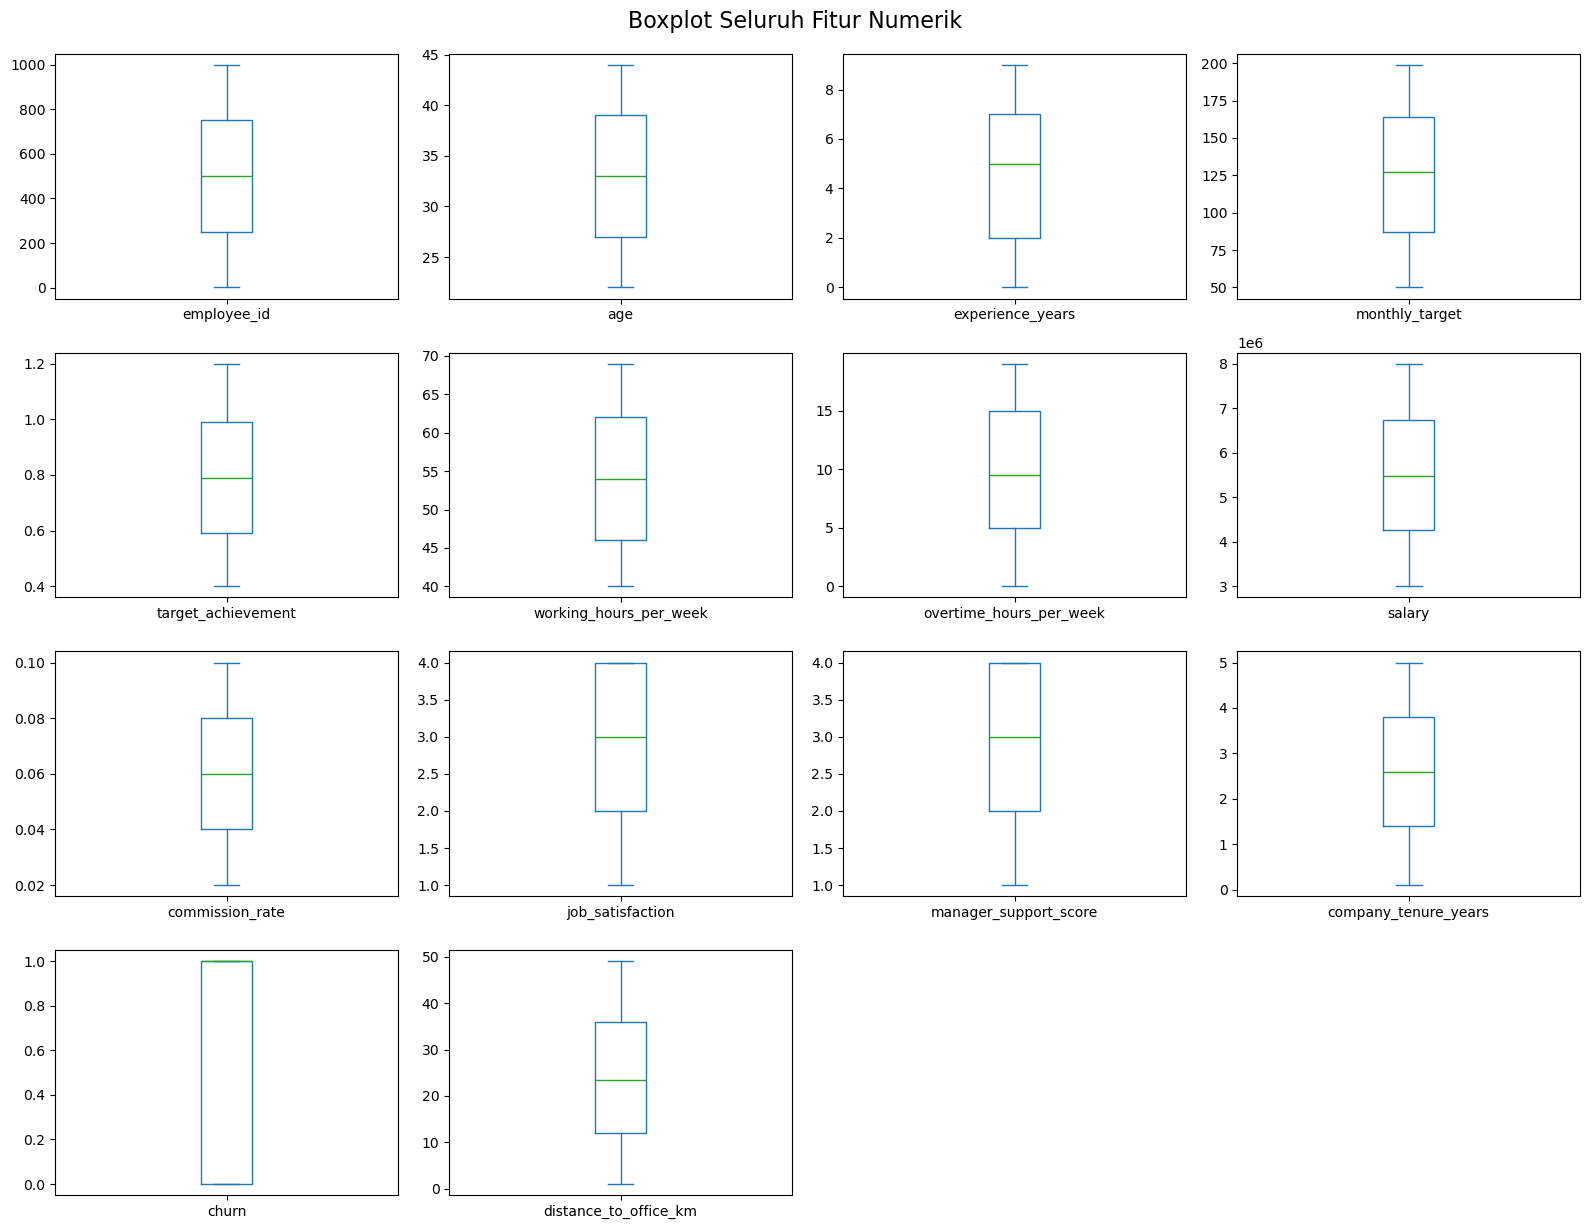

In [25]:
numerics = df.select_dtypes(include=np.number).columns

df[numerics].plot(kind='box', subplots=True, layout=(4, 4), figsize=(16, 12), sharex=False, sharey=False)
plt.tight_layout()
plt.suptitle("Boxplot Seluruh Fitur Numerik", fontsize=16, y=1.02)
plt.show()

### 📊 Insight Penting:
- **Sebagian besar fitur** memiliki distribusi normal dengan sebaran yang baik.
- **Fitur hasil rekayasa**:
  - `total_hours_per_week`: Terdistribusi merata, tidak ada outlier mencolok.
  - `target_ratio`: Terdapat beberapa nilai outlier di atas batas atas, namun masih dalam rentang yang masuk akal secara bisnis (rasio target bisa sangat tinggi bila target kecil namun pencapaian besar).
- Fitur asli seperti `salary`, `working_hours_per_week`, dan `distance_to_office_km` menunjukkan sebaran simetris tanpa nilai ekstrem.



# Univariate Analysis

## Univariate Analysis: Numerical Features

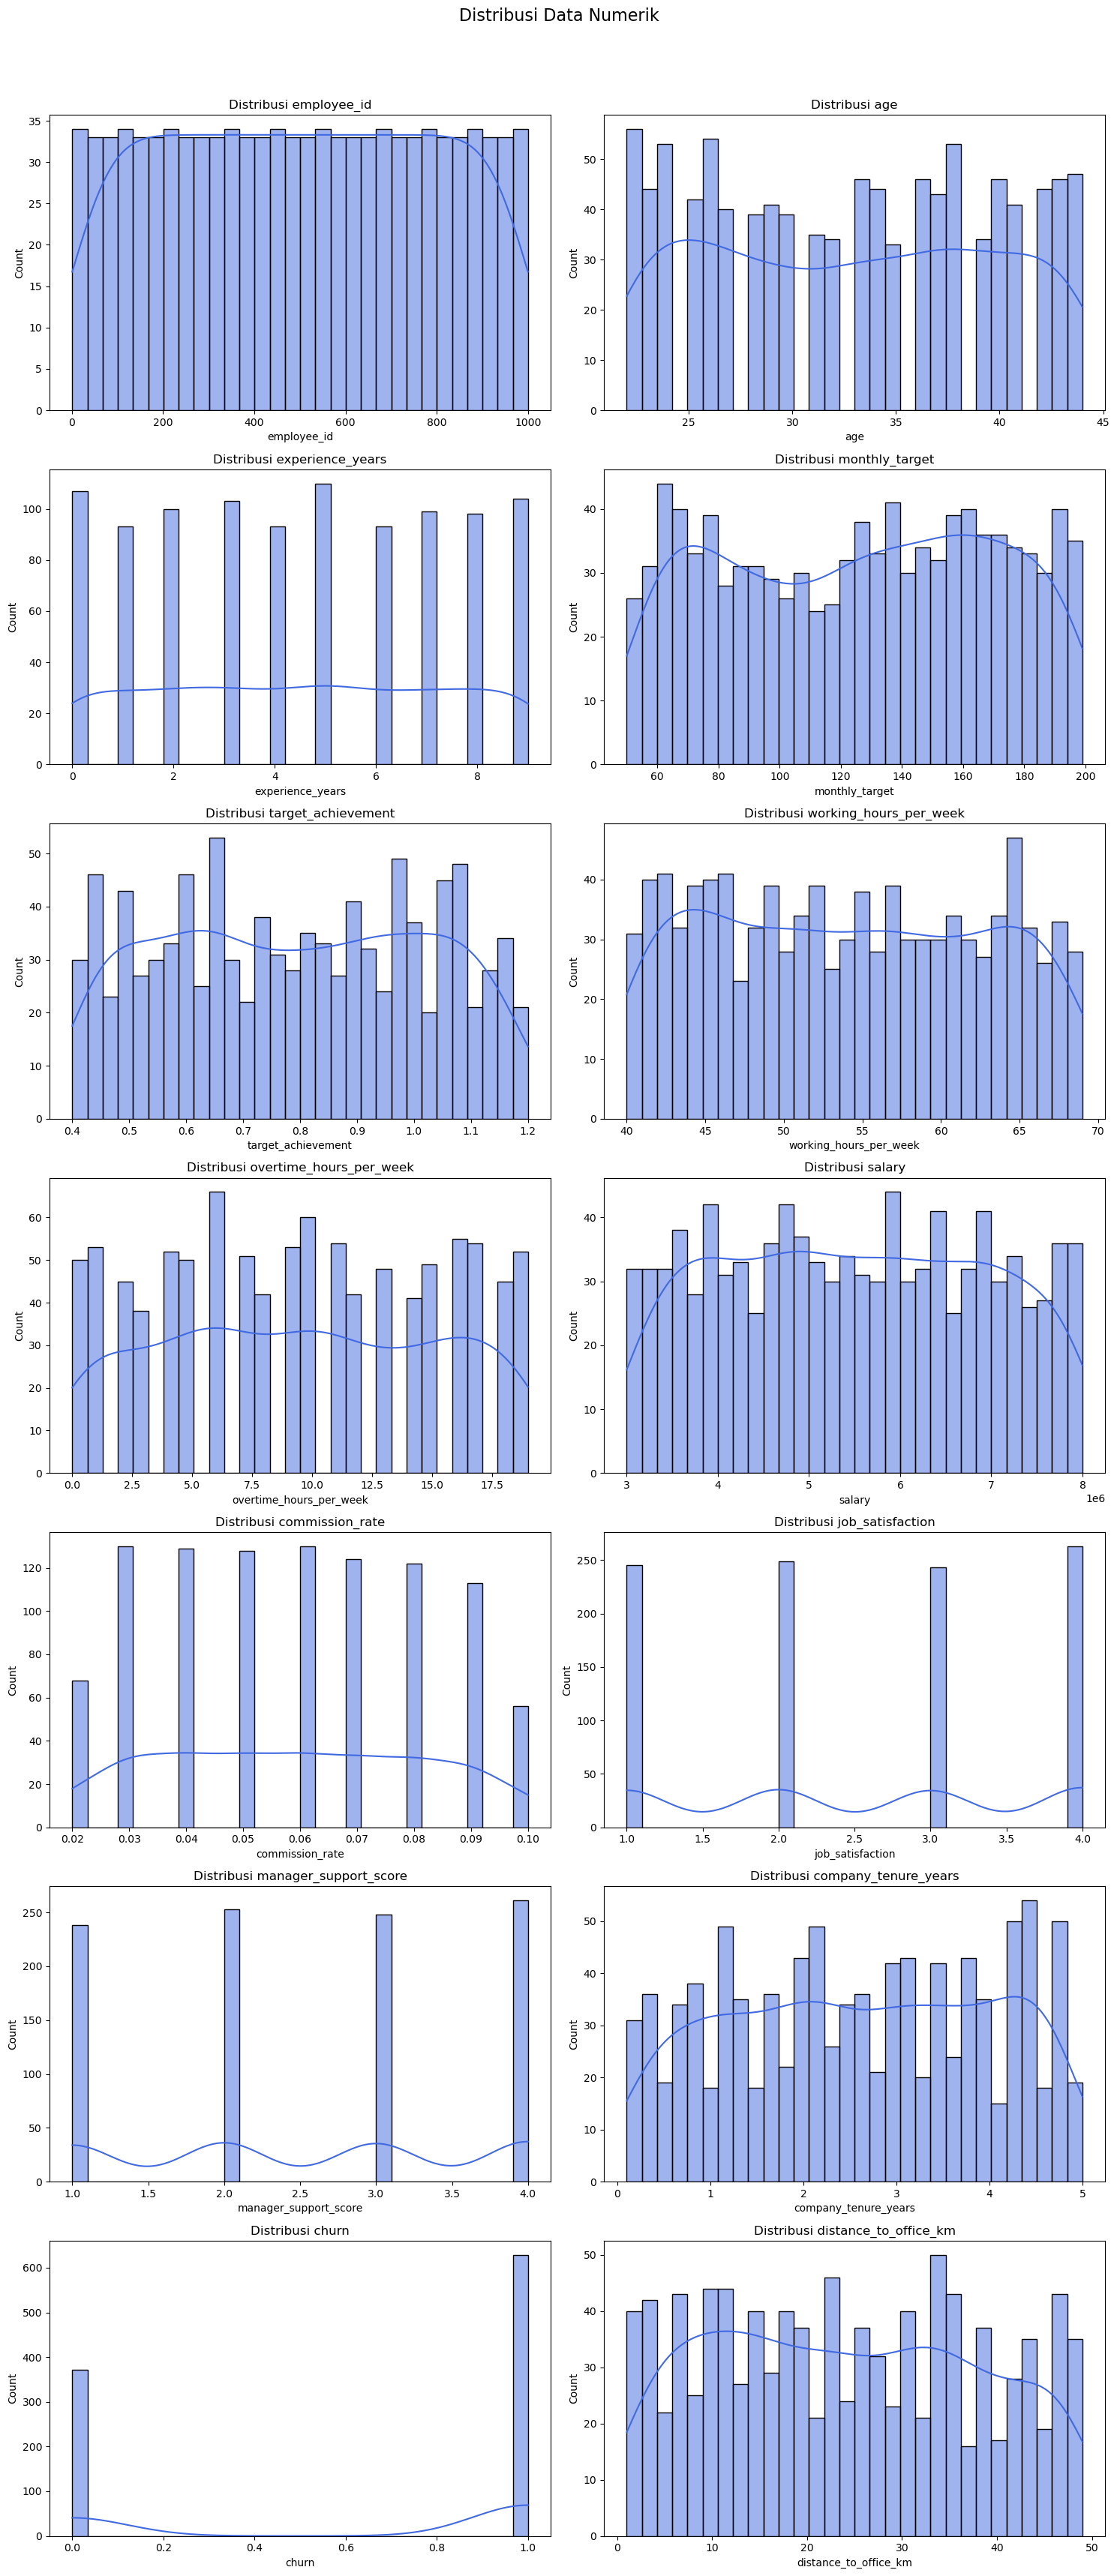

In [29]:
## Visualisasi distribusi variabel numerik
num_cols = df.select_dtypes(include=["number"]).columns.tolist()

n_rows = (len(num_cols) + 1) // 2
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 5 * n_rows))
fig.suptitle("Distribusi Data Numerik", fontsize=16)

# Flatten axes agar indexing selalu 1D
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color="royalblue")
    axes[i].set_title(f"Distribusi {col}", fontsize=12)

# Hilangkan sisa subplot kosong (jika ada)
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- **Distribusi usia & pengalaman kerja** cukup normal, tetapi beberapa karyawan memiliki **0 tahun pengalaman** (perlu dicek lebih lanjut).
- **Target bulanan dan pencapaian target** menunjukkan distribusi yang miring, beberapa karyawan memiliki pencapaian lebih dari 1.2x target.
- **Jam kerja dan lembur** menunjukkan mayoritas karyawan bekerja **40-69 jam per minggu**.
- **Gaji** memiliki distribusi yang luas, beberapa karyawan mendapat gaji **lebih dari 7 juta** (indikasi outlier).
- **Jarak ke kantor** menunjukkan distribusi lebar, ada yang bekerja dari **1 km hingga 49 km**.

Sebagian besar distribusi terlihat normal atau sedikit right-skewed (gaji, jam kerja).

Ini memberikan indikasi awal yang bagus untuk pemodelan atau transformasi data jika dibutuhkan.

## Univariate Analysis: Categorical Features

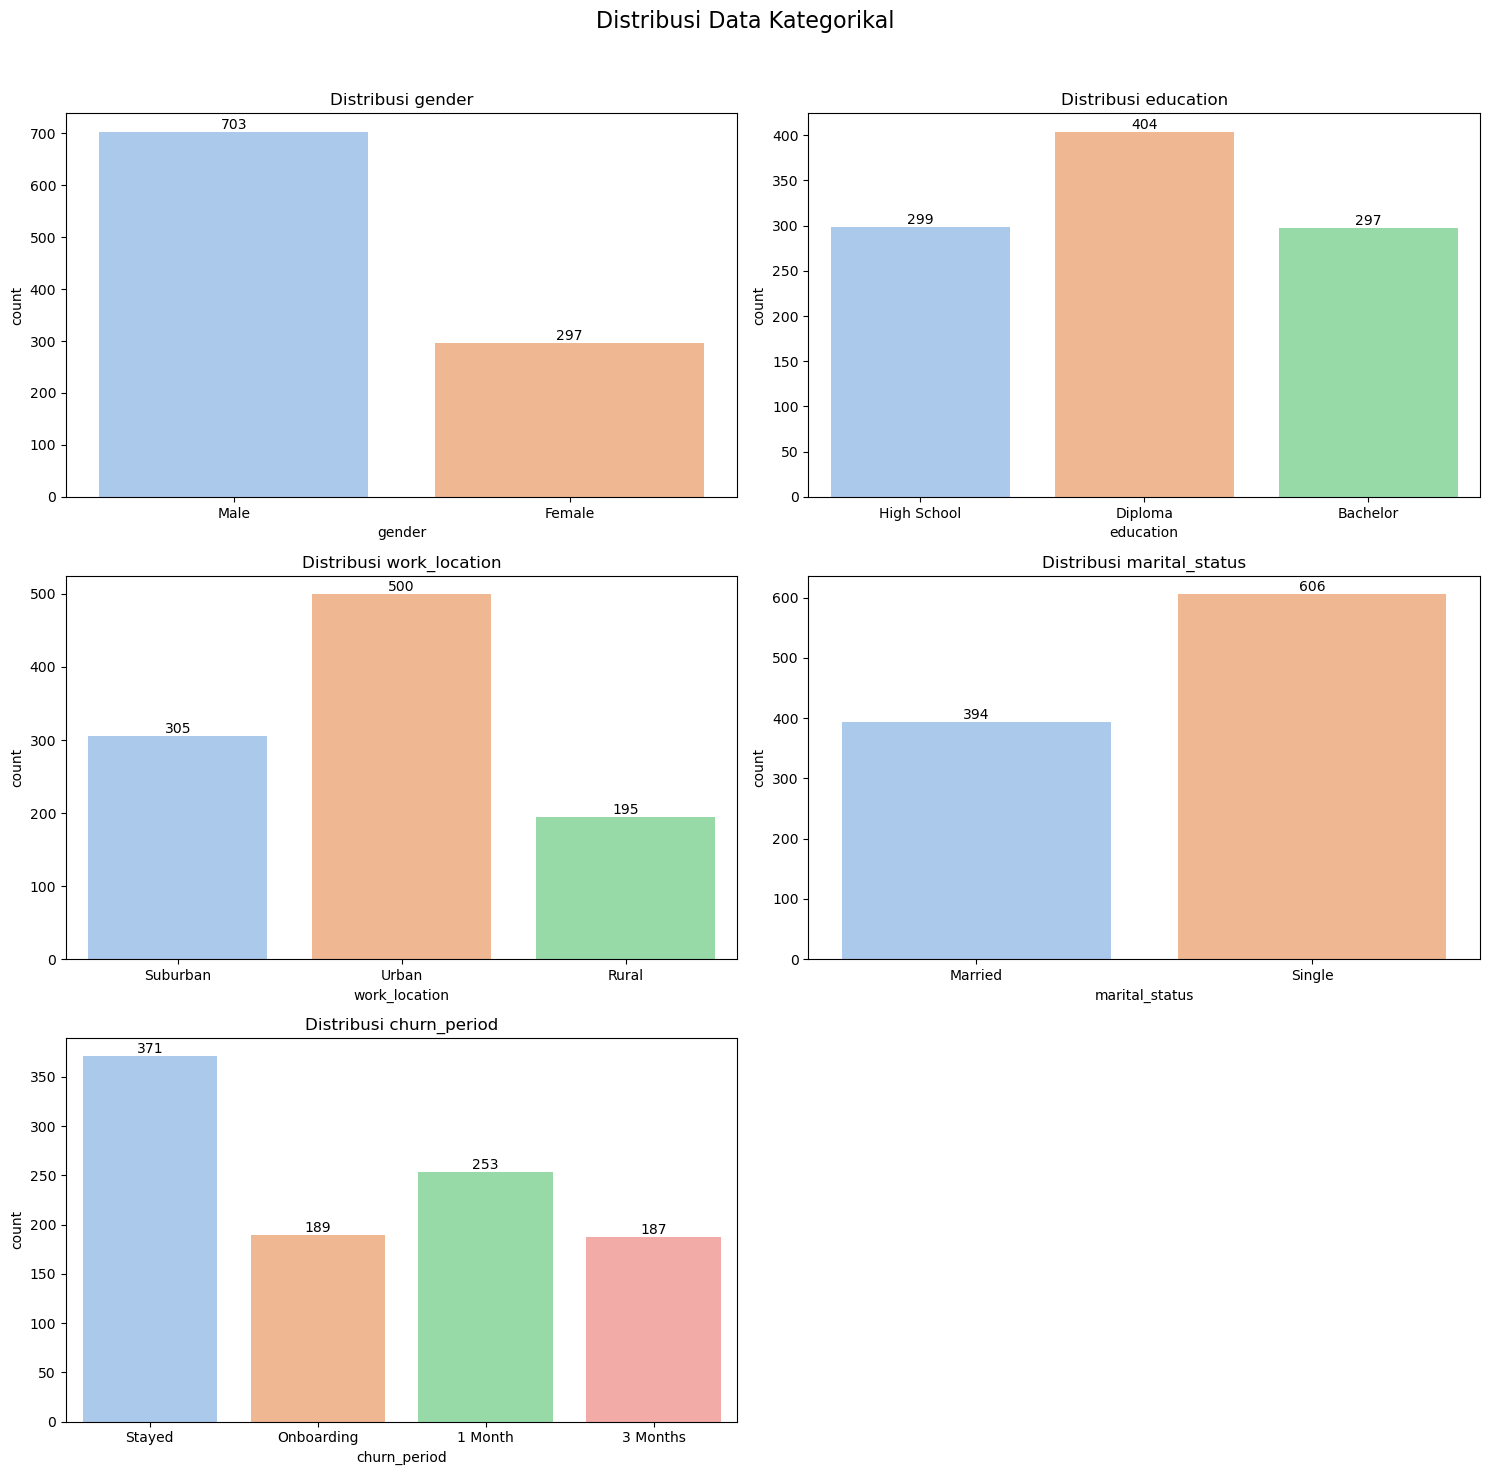

In [32]:
## Visualisasi distribusi variabel kategorikal
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Menyesuaikan jumlah baris dan kolom subplot agar cukup untuk semua kategori
n_cols = 2  # Jumlah kolom subplot
n_rows = (len(cat_cols) + 1) // n_cols  # Menentukan jumlah baris berdasarkan jumlah kategori

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
fig.suptitle("Distribusi Data Kategorikal", fontsize=16)

# Flatten axes jika hanya ada satu baris agar tidak terjadi error
axes = axes.flatten() if n_rows > 1 else np.array([axes]).flatten()

for i, col in enumerate(cat_cols):
    ax = sns.countplot(data=df, x=col, palette="pastel", ax=axes[i])
    axes[i].set_title(f"Distribusi {col}", fontsize=12)
    axes[i].set_xticklabels(axes[i].get_xticklabels())
    for cont in ax.containers:
      ax.bar_label(cont)

# Sembunyikan subplot kosong jika jumlah kategori ganjil
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Cek Outliers via Boxplot (Univariate Analysis)

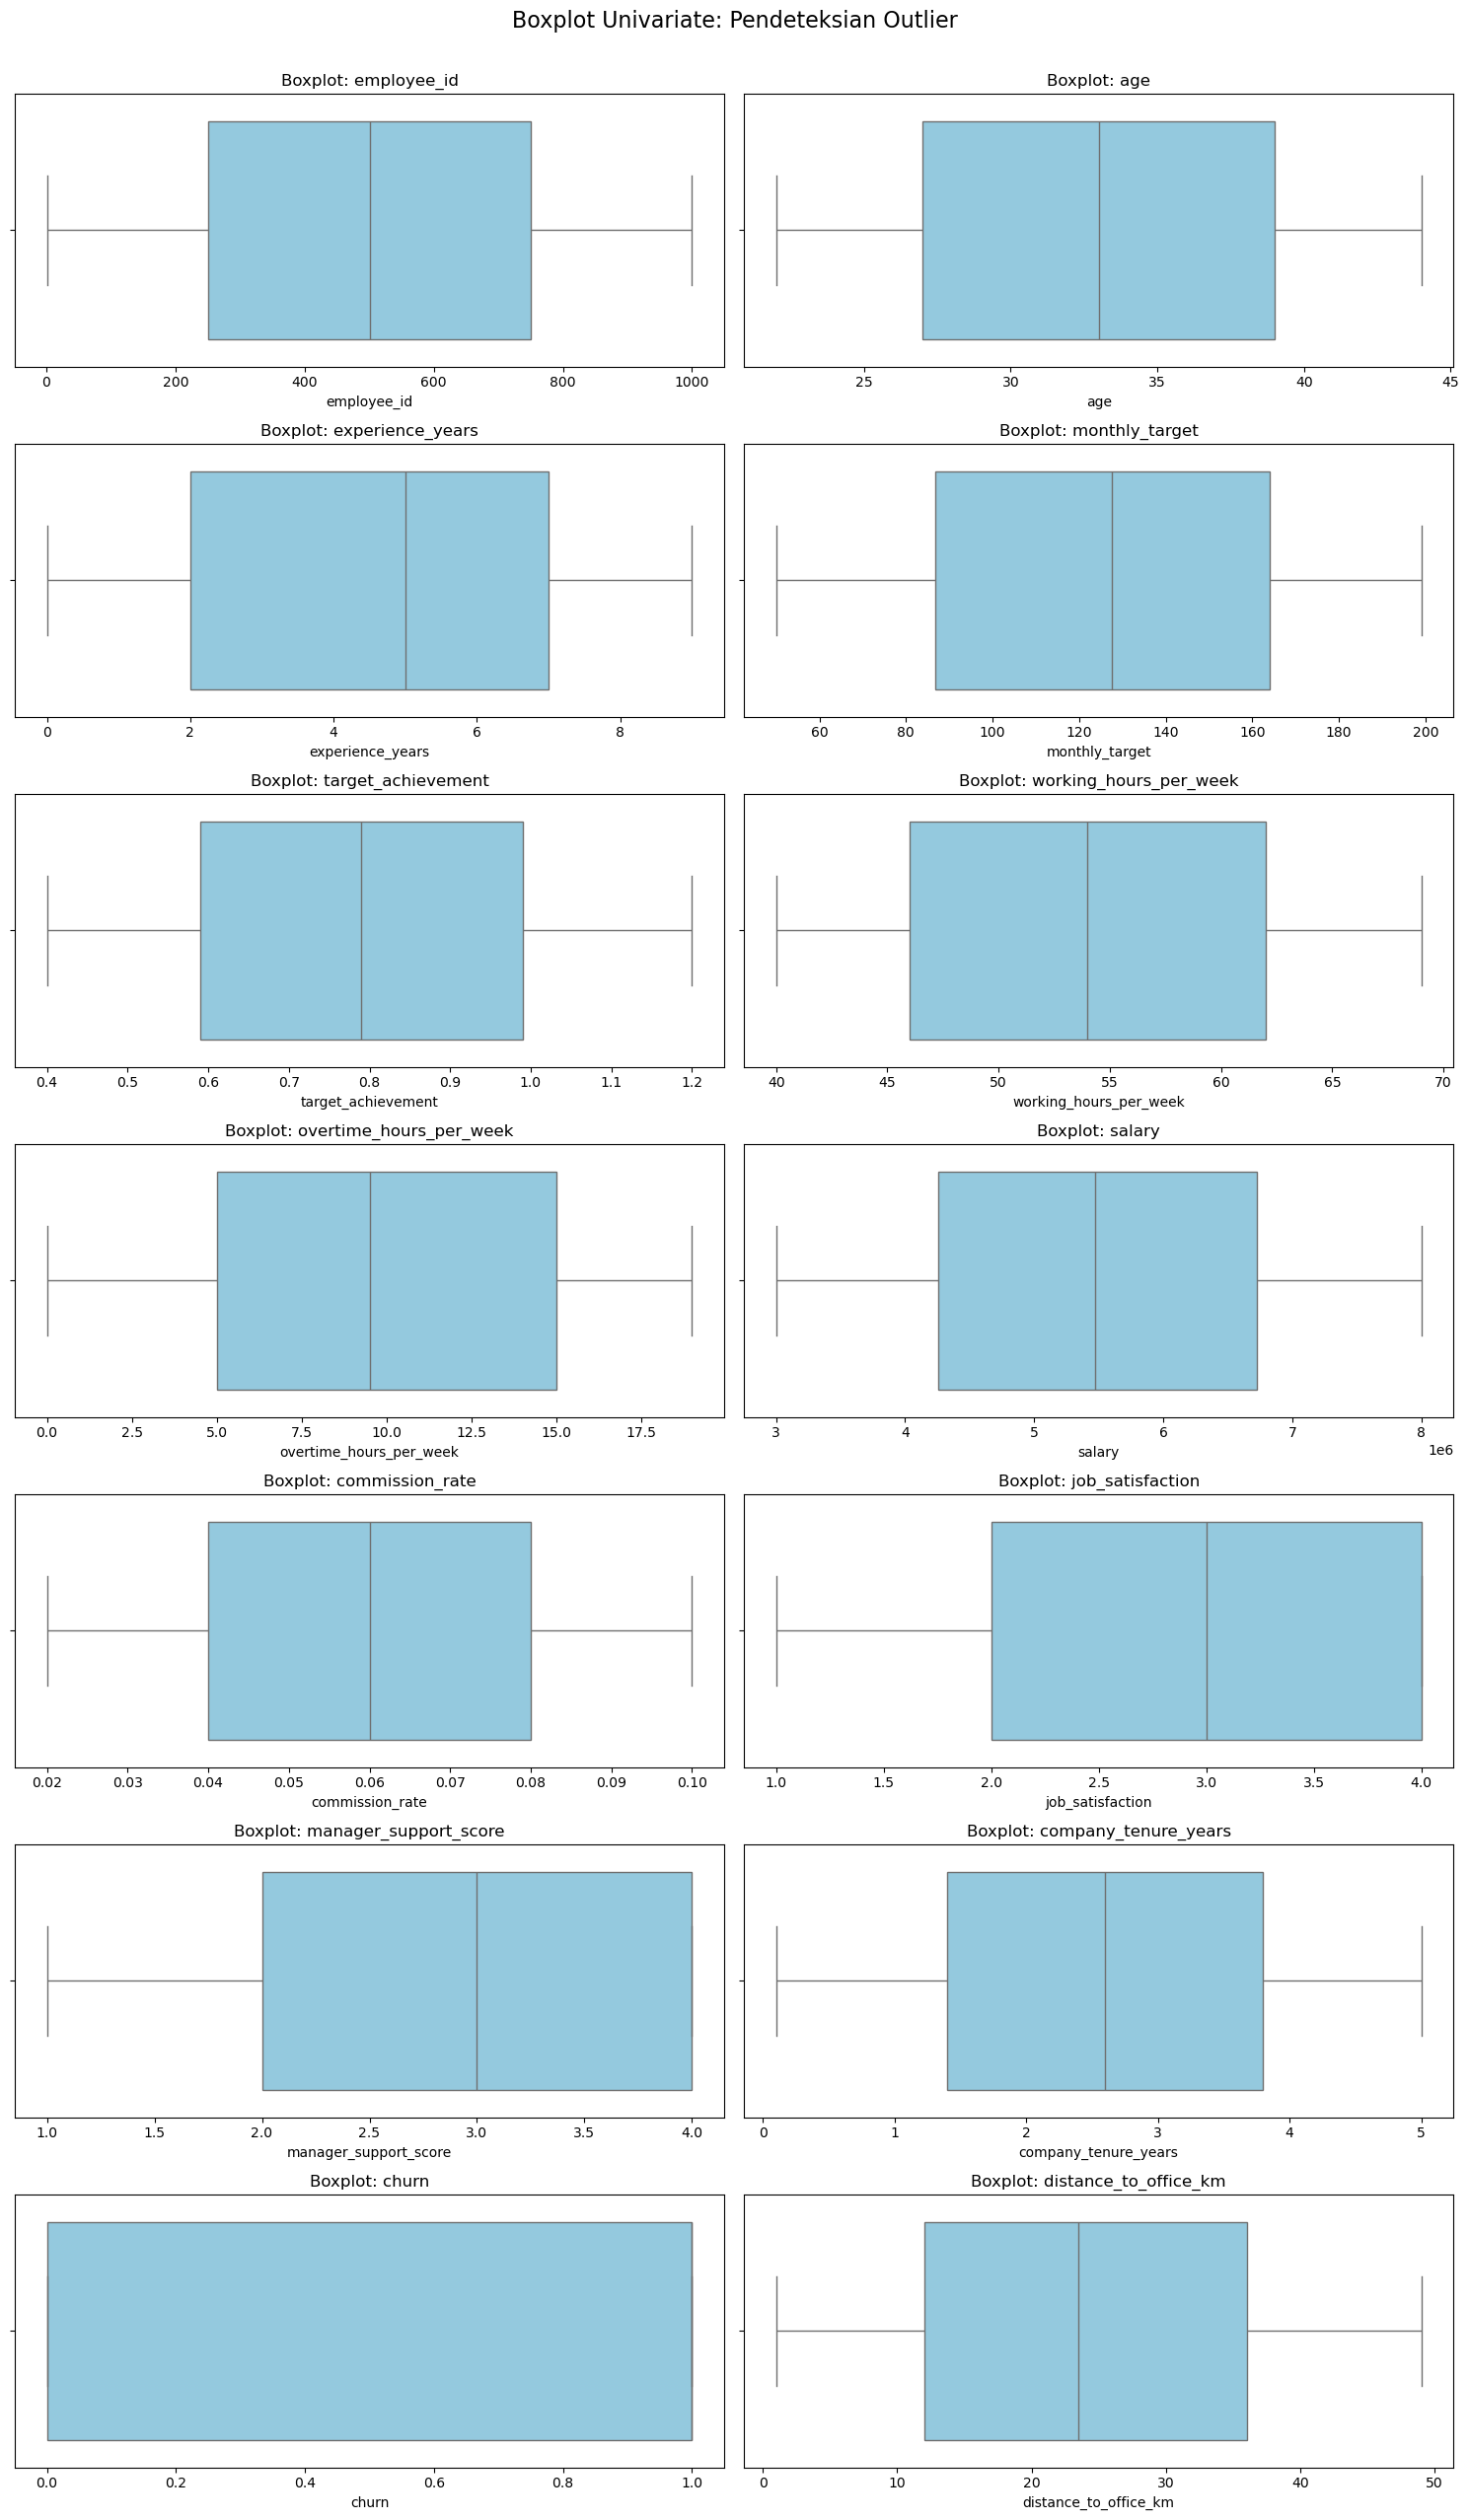

In [34]:
# Visualisasi Boxplot tiap fitur numerik
fig, axes = plt.subplots(nrows=len(num_cols)//2 + len(num_cols)%2, ncols=2, figsize=(15, 25))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Boxplot: {col}", fontsize=12)

# Hapus sisa subplot kosong jika jumlah fitur ganjil
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Boxplot Univariate: Pendeteksian Outlier", fontsize=16, y=1.02)
plt.show()

## Multivariate Analysis

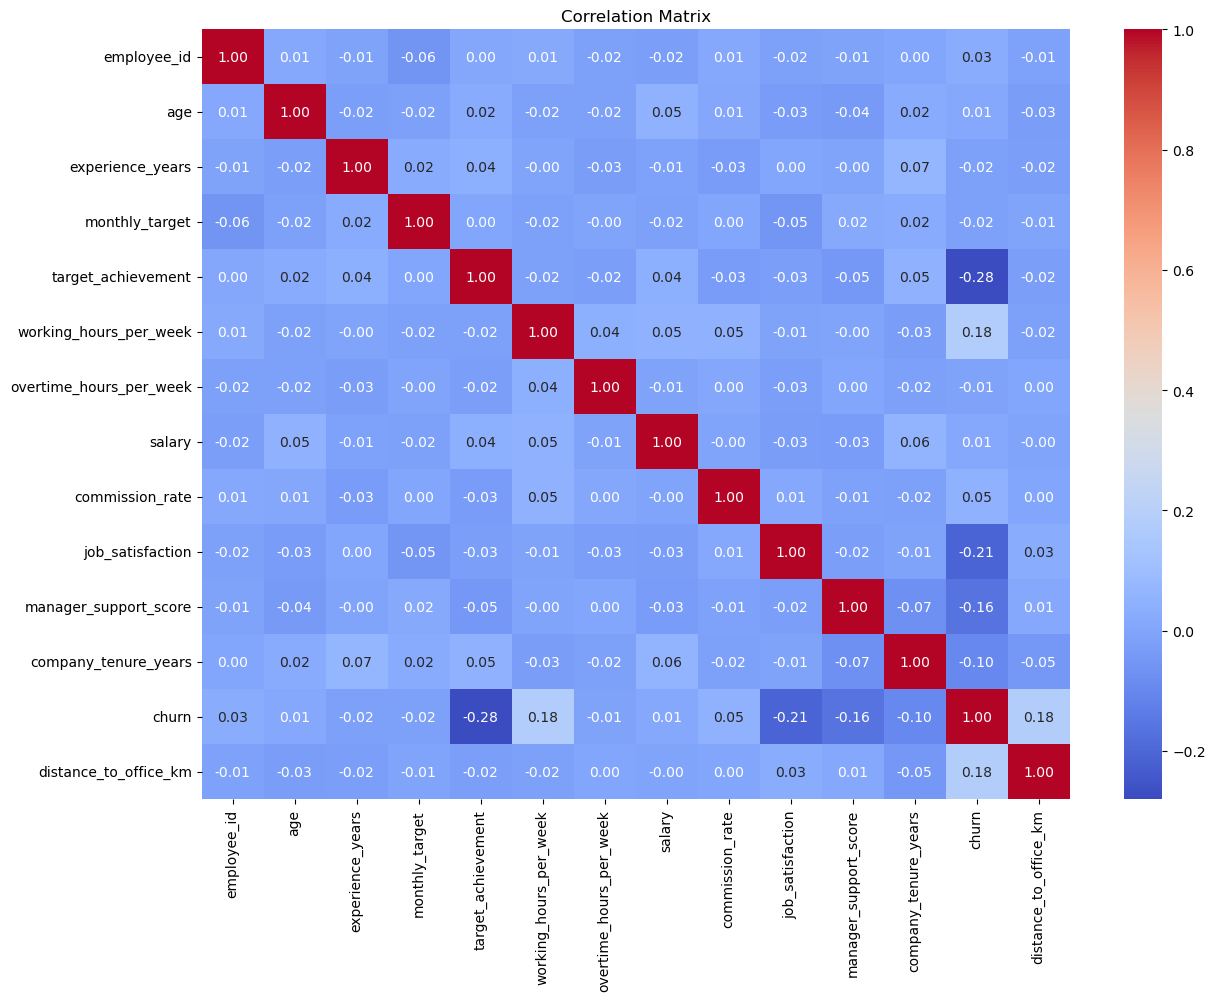

In [36]:
# Korelasi antar fitur numerik
plt.figure(figsize=(14,10))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### 🔗 Multivariate Analysis: Korelasi Antar Fitur Numerik

**🔍 Tujuan Analisis:**
Untuk memahami hubungan antar fitur numerik dan mengidentifikasi **faktor-faktor yang paling berkorelasi dengan churn**, baik secara positif maupun negatif.

---

### ✅ Hasil Pemeriksaan Korelasi:
- Korelasi dihitung menggunakan matriks korelasi Pearson.
- Sebagian besar fitur memiliki korelasi rendah satu sama lain, menunjukkan **tidak ada multikolinearitas kuat**.
- Fokus utama adalah korelasi terhadap variabel **`churn`**.

---

### 📌 Insight Utama terhadap `churn`:

| Fitur                   | Korelasi   | Interpretasi                                                                 |
|------------------------|------------|------------------------------------------------------------------------------|
| `target_achievement`   | **-0.28**  | Semakin rendah pencapaian target, semakin besar kemungkinan karyawan churn. |
| `job_satisfaction`     | **-0.21**  | Ketidakpuasan kerja berkontribusi signifikan terhadap churn.                |
| `manager_support_score`| **-0.16**  | Rendahnya dukungan dari manajer terkait dengan kemungkinan karyawan keluar. |
| `working_hours_per_week` | **+0.18** | Jam kerja yang tinggi sedikit berhubungan dengan churn.                     |
| `distance_to_office_km`  | **+0.18** | Jarak tempat tinggal ke kantor juga punya pengaruh ke churn.                |

---

### 🎯 Kesimpulan:
- Fitur yang berkorelasi negatif terhadap churn seperti `target_achievement`, `job_satisfaction`, dan `manager_support_score` **berpotensi sebagai variabel penting dalam pemodelan prediktif churn**.
- Insight ini juga mendukung pentingnya strategi **employee engagement dan support system** dalam mengurangi churn.


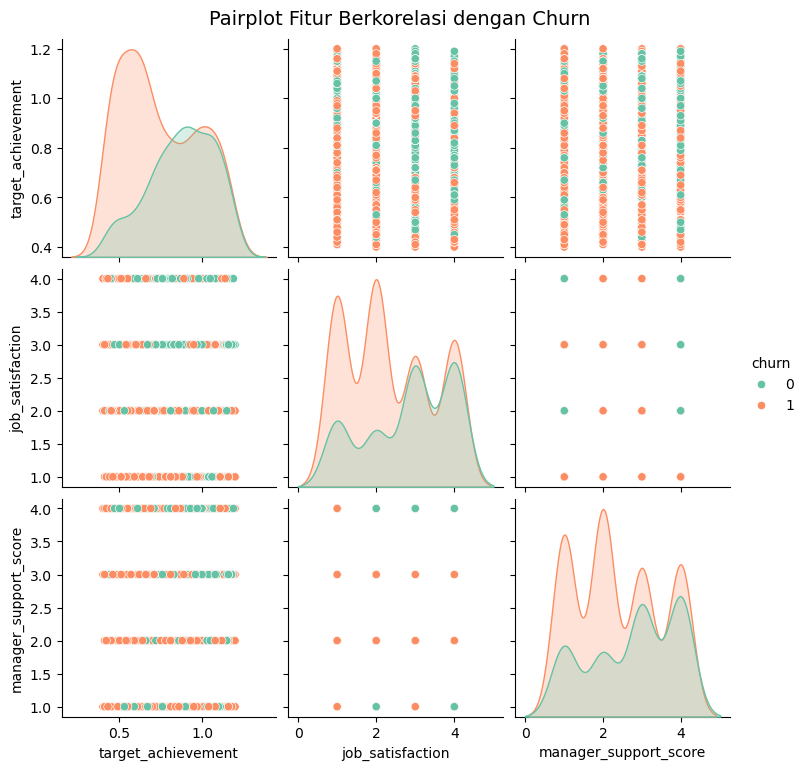

In [38]:
# Visualisasi hubungan antar fitur yang berkorelasi tinggi dengan churn
# Menggunakan pairplot untuk melihat pola antar variabel numerik terhadap churn


selected_cols = ['target_achievement', 'job_satisfaction', 'manager_support_score', 'churn']
sns.pairplot(df[selected_cols], hue='churn', palette='Set2')
plt.suptitle("Pairplot Fitur Berkorelasi dengan Churn", fontsize=14, y=1.02)
plt.show()



### 🔍 Pairplot Fitur yang Berkaitan dengan Churn

**🎯 Tujuan:**
Mengeksplorasi hubungan visual antara **`churn`** dan tiga fitur yang paling berkorelasi dengannya, yaitu:
- `target_achievement`
- `job_satisfaction`
- `manager_support_score`

---

### ✅ Insight dari Pairplot:

- **`target_achievement`**  
  → Terlihat bahwa sebagian besar karyawan yang churn (warna oranye) memiliki pencapaian target yang **lebih rendah** dibandingkan yang tidak churn.

- **`job_satisfaction`**  
  → Karyawan yang churn cenderung memiliki tingkat kepuasan kerja **lebih rendah (nilai 1–2)** dibanding yang bertahan (yang lebih merata atau cenderung ke nilai 3–4).

- **`manager_support_score`**  
  → Distribusi churn juga lebih tinggi pada karyawan dengan **dukungan manajer yang rendah**, mendukung insight bahwa **lingkungan kerja berperan besar dalam retensi**.

---

### 📌 Kesimpulan:
Visualisasi ini memperkuat hasil korelasi bahwa fitur `target_achievement`, `job_satisfaction`, dan `manager_support_score` merupakan indikator kuat churn, dan sangat relevan untuk **pemodelan prediktif maupun rekomendasi strategis HR**.


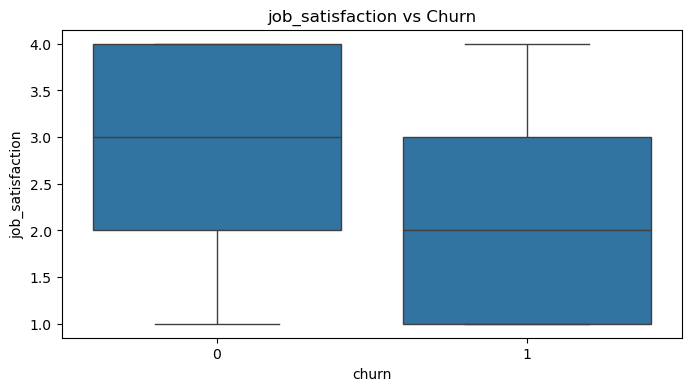

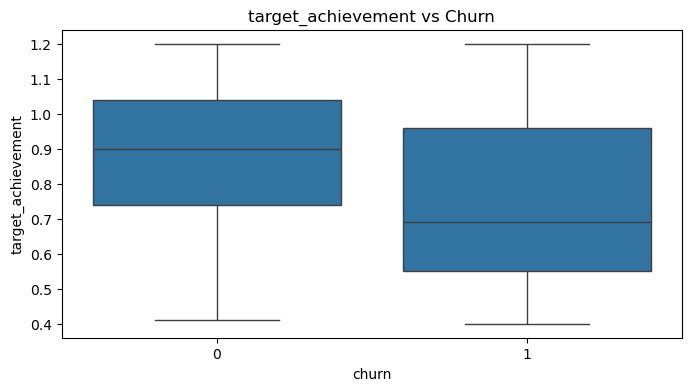

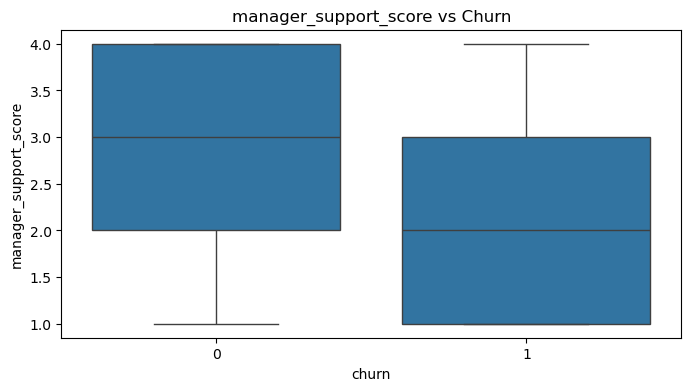

In [40]:
# Visualisasi Boxplot untuk melihat distribusi fitur penting berdasarkan status churn

# Fitur numerik yang relevan
selected_cols = ['job_satisfaction', 'target_achievement', 'manager_support_score']

for col in selected_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='churn', y=col, data=df)
    plt.title(f'{col} vs Churn')
    plt.show()


### 📌 Penjelasan:
Boxplot ini menunjukkan **perbedaan distribusi nilai fitur numerik** antara karyawan yang churn (`churn = 1`) dan tidak churn (`churn = 0`):

- **`job_satisfaction`**  
  → Rata-rata kepuasan kerja lebih tinggi pada karyawan yang bertahan.  
  Karyawan yang churn cenderung berada pada level kepuasan kerja yang lebih rendah.

- **`target_achievement`**  
  → Karyawan yang churn memiliki pencapaian target lebih rendah secara umum.

- **`manager_support_score`**  
  → Dukungan manajer lebih tinggi pada karyawan yang tidak churn.  
  Distribusi median untuk churn terlihat lebih rendah dan padat di skor 1–2.


# Preprocessing

## Missing Values Cleansing

In [44]:
df.isnull().sum()

employee_id                0
age                        0
gender                     0
education                  0
experience_years           0
monthly_target             0
target_achievement         0
working_hours_per_week     0
overtime_hours_per_week    0
salary                     0
commission_rate            0
job_satisfaction           0
work_location              0
manager_support_score      0
company_tenure_years       0
churn                      0
marital_status             0
distance_to_office_km      0
churn_period               0
dtype: int64

In [45]:
# --- 1. CEK MISSING VALUES ---
print("🔍 [1] CEK MISSING VALUES")
missing = df.isnull().sum()
missing_total = missing.sum()

if missing_total == 0:
    print("✅ Tidak ada missing values. Data aman.")
else:
    print("⚠️ Terdapat missing values:")
    print(missing[missing > 0])
    print("\n💡 Saran: Imputasi nilai yang hilang, misalnya dengan mean/median (numerik) atau modus (kategorikal).")

🔍 [1] CEK MISSING VALUES
✅ Tidak ada missing values. Data aman.


#### 🔍 Duplicate Cleansing

In [47]:
df.duplicated().sum()

0

In [48]:
# --- 2. CEK DUPLIKAT ---
print("\n🔍 [2] CEK DUPLIKAT")
duplicates = df.duplicated().sum()

if duplicates == 0:
    print("✅ Tidak ada data duplikat. Data aman.")
else:
    print(f"⚠️ Terdapat {duplicates} baris duplikat.")
    print("💡 Saran: Gunakan `df.drop_duplicates()` untuk menghapus baris yang duplikat.")


🔍 [2] CEK DUPLIKAT
✅ Tidak ada data duplikat. Data aman.


## Outlier Cleansing

In [50]:
# Menghapus outlier menggunakan IQR method
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Jumlah data setelah outlier cleansing: {df.shape[0]} dari {df.shape[0]} baris awal")

Jumlah data setelah outlier cleansing: 1000 dari 1000 baris awal


In [51]:
print("\n🔍 [3] CEK OUTLIER (Metode IQR)")

def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
outlier_report = {}

for col in numeric_cols:
    outliers = detect_outliers_iqr(df[col])
    count_outliers = len(outliers)
    outlier_report[col] = count_outliers

# Tampilkan hasil outlier
outlier_df = pd.DataFrame.from_dict(outlier_report, orient='index', columns=['Jumlah Outlier'])
print(outlier_df)

# Interpretasi
total_outliers = outlier_df['Jumlah Outlier'].sum()

if total_outliers == 0:
    print("\n✅ Tidak ditemukan outlier yang signifikan. Data aman.")
else:
    print(f"\n⚠️ Terdapat {total_outliers} nilai outlier dalam data.")
    print("💡 Saran:")
    print("- Analisis apakah outlier tersebut valid secara bisnis (contoh: gaji tinggi bisa wajar).")
    print("- Jika tidak valid, pertimbangkan: trimming, winsorizing, atau transformasi log/Box-Cox.")


🔍 [3] CEK OUTLIER (Metode IQR)
                         Jumlah Outlier
employee_id                           0
age                                   0
experience_years                      0
monthly_target                        0
target_achievement                    0
working_hours_per_week                0
overtime_hours_per_week               0
salary                                0
commission_rate                       0
job_satisfaction                      0
manager_support_score                 0
company_tenure_years                  0
churn                                 0
distance_to_office_km                 0

✅ Tidak ditemukan outlier yang signifikan. Data aman.


Menggunakan metode IQR (Interquartile Range):

Tidak ditemukan outlier di kolom numerik manapun. Data bersih dari nilai ekstrem yang mencurigakan.

## Drop identifier & basic checks

In [54]:
df = df.drop(columns=["employee_id"])        # kolom ID tidak informatif
print(df.isna().sum().sort_values(ascending=False).head())  # cek nilai hilang
df.head()

age                      0
gender                   0
distance_to_office_km    0
marital_status           0
churn                    0
dtype: int64


,age,gender,education,experience_years,monthly_target,target_achievement,working_hours_per_week,overtime_hours_per_week,salary,commission_rate,job_satisfaction,work_location,manager_support_score,company_tenure_years,churn,marital_status,distance_to_office_km,churn_period
0,28,Male,High School,0,153,0.94,62,9,4667108,0.03,4,Suburban,3,2.8,0,Married,22,Stayed
1,41,Male,Diploma,6,188,0.54,55,8,5853507,0.06,3,Urban,3,2.7,1,Single,36,Onboarding
2,36,Female,High School,8,159,0.44,59,10,4781336,0.07,1,Urban,2,1.7,1,Single,17,Onboarding
3,32,Male,Diploma,7,185,0.66,68,15,3624588,0.05,1,Urban,2,0.5,1,Married,32,Onboarding
4,29,Female,High School,7,142,1.01,45,9,5154327,0.08,3,Rural,2,4.5,0,Single,14,Stayed


In [55]:
df['total_hours_per_week'] = df['working_hours_per_week'] + df['overtime_hours_per_week']
df['target_ratio'] = df['target_achievement'] / (df['monthly_target'] + 1)
df = df.drop(columns=[col for col in df.columns if col.startswith("churn_period")])

# Feature Engineering

## Fungsi numeric features

In [58]:
def add_numeric_features(data: pd.DataFrame) -> pd.DataFrame:
    """Tambahkan fitur numerik baru ke dataframe."""

    # Rasio lembur (tangani div/0)
    data["overtime_ratio"] = (
        data["overtime_hours_per_week"]
        / data["working_hours_per_week"].replace(0, np.nan)
    ).fillna(0)

    # Selisih capaian target
    data["target_gap"] = 1 - data["target_achievement"]

    # Bendera kinerja buruk (<90 %)
    data["underperform_flag"] = (data["target_achievement"] < 0.9).astype("int8")

    # Interaksi kinerja × kepuasan
    data["perf_satisfaction"] = (
        data["target_achievement"] * data["job_satisfaction"]
    )

    return data

df = add_numeric_features(df)
df[["overtime_ratio", "target_gap", "underperform_flag", "perf_satisfaction"]].head()

,overtime_ratio,target_gap,underperform_flag,perf_satisfaction
0,0.145161,0.06,0,3.76
1,0.145455,0.46,1,1.62
2,0.169492,0.56,1,0.44
3,0.220588,0.34,1,0.66
4,0.200000,-0.01,0,3.03


## Box‑Cox untuk numeric continuous

In [60]:
def apply_boxcox_with_offset(data: pd.DataFrame, cols) -> pd.DataFrame:
    """
    Terapkan Box‑Cox pada kolom numerik.
    Jika ada nilai ≤0 tambahkan offset +1 agar positif.
    """
    for col in cols:
        if np.any(data[col] <= 0):
            data[col] += 1
        transformed, _ = boxcox(data[col])
        data[f"{col}_boxcox"] = transformed
    return data

# Contoh: transform overtime_ratio & target_gap
boxcox_cols = ["overtime_ratio", "target_gap"]
df = apply_boxcox_with_offset(df, boxcox_cols)

## Visualisasi sebelum vs sesudah (Box‑Cox)

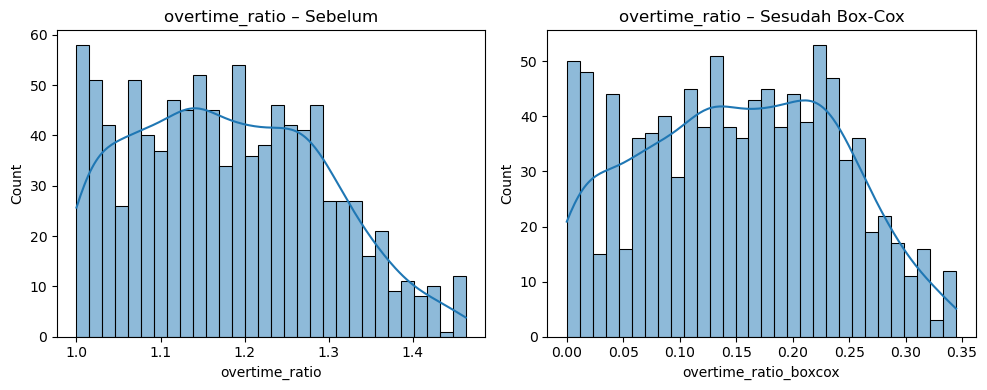

In [62]:
def plot_before_after(feature: str):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f"{feature} – Sebelum")

    sns.histplot(df[f"{feature}_boxcox"], bins=30, kde=True, ax=axes[1])
    axes[1].set_title(f"{feature} – Sesudah Box‑Cox")
    plt.tight_layout()
    plt.show()

plot_before_after("overtime_ratio")

## Cek & ubah tipe data dasar

In [64]:
# Cek tipe data awal
print(df.dtypes.value_counts())      # ringkasan tipe
df.head()

int64      11
float64     9
object      4
int8        1
Name: count, dtype: int64


,age,gender,education,experience_years,monthly_target,target_achievement,working_hours_per_week,overtime_hours_per_week,salary,commission_rate,...,marital_status,distance_to_office_km,total_hours_per_week,target_ratio,overtime_ratio,target_gap,underperform_flag,perf_satisfaction,overtime_ratio_boxcox,target_gap_boxcox
0,28,Male,High School,0,153,0.94,62,9,4667108,0.03,...,Married,22,71,0.006104,1.145161,1.06,0,3.76,0.130777,0.059606
1,41,Male,Diploma,6,188,0.54,55,8,5853507,0.06,...,Single,36,63,0.002857,1.145455,1.46,1,1.62,0.131016,0.439831
2,36,Female,High School,8,159,0.44,59,10,4781336,0.07,...,Single,17,69,0.002750,1.169492,1.56,1,0.44,0.150231,0.531002
3,32,Male,Diploma,7,185,0.66,68,15,3624588,0.05,...,Married,32,83,0.003548,1.220588,1.34,1,0.66,0.189135,0.328549
4,29,Female,High School,7,142,1.01,45,9,5154327,0.08,...,Single,14,54,0.007063,1.200000,0.99,0,3.03,0.173765,-0.010011


In [65]:
# Konversi flag ke tipe int8 (hemat memori)
df["underperform_flag"] = df["underperform_flag"].astype("int8")

## Label Encoding

In [67]:
print(df.columns.tolist())

['age', 'gender', 'education', 'experience_years', 'monthly_target', 'target_achievement', 'working_hours_per_week', 'overtime_hours_per_week', 'salary', 'commission_rate', 'job_satisfaction', 'work_location', 'manager_support_score', 'company_tenure_years', 'churn', 'marital_status', 'distance_to_office_km', 'total_hours_per_week', 'target_ratio', 'overtime_ratio', 'target_gap', 'underperform_flag', 'perf_satisfaction', 'overtime_ratio_boxcox', 'target_gap_boxcox']


In [68]:
# Checking setiap value di column

for i in df.columns:
    print(f"{[i]} \n {df[i].unique()} \n")

['age'] 
 [28 41 36 32 29 42 40 44 25 24 43 23 33 27 22 38 31 37 26 30 39 35 34] 

['gender'] 
 ['Male' 'Female'] 

['education'] 
 ['High School' 'Diploma' 'Bachelor'] 

['experience_years'] 
 [0 6 8 7 5 3 2 1 9 4] 

['monthly_target'] 
 [153 188 159 185 142 143 105 109 187  88  77  98 174  62  85 150  75 135
  53 131 176 137 169  71 179  80 168  60  95 145  59 177 148 161 136 194
 114 106 155  58 190 138  67 164 192  64 112 130  81 186  89 197 126 125
  87 120  97 193 111 158 183 139  63 144 103 181 121  74 102 180 199  55
 108 118 101 133  94 163  69 178  66 107  72  57 160  65  51  79 152 198
 104 165 157  50  93 124 147 189  61 156  91 134 151 132 196  86 117  92
 154 146 191  83 116 167 122  54  76 162 115 171  70 170 182 119  96 140
 110 100 172 128 127 195 184  68 149  99  52  73 166 175  90  84 123 113
  56 173  78 141 129  82] 

['target_achievement'] 
 [0.94 0.54 0.44 0.66 1.01 0.73 0.92 0.86 0.42 1.19 0.43 1.17 0.84 0.49
 0.79 0.89 0.57 0.87 0.67 1.03 0.75 0.9  1.08 0.95 0.

In [69]:
# Encode kolom ORDINAL
if "tenure_bucket" in df.columns:
    df["tenure_bucket"] = df["tenure_bucket"].astype(str).str.replace("‑", "-", regex=False)

ordinal_map = {
    "education":     ["High School", "Diploma", "Bachelor"],
    "distance_bin":  ["near", "mid", "far"],
    "tenure_bucket": ["<1", "1-3", "3-7", ">7"],
    "work_location": ["Rural", "Suburban", "Urban"],
    "churn_period":  ["Onboarding", "1 Month", "3 Months", "Stayed"],
}

# --- pilih hanya kolom yang masih object (belum ter‑encode) ---
ordinal_cols = [c for c in ordinal_map if c in df.columns and df[c].dtype == "object"]

if ordinal_cols:
    ord_enc = OrdinalEncoder(
        categories=[ordinal_map[c] for c in ordinal_cols],
        dtype="int8",
        handle_unknown="use_encoded_value",
        unknown_value=-1
    )
    df[ordinal_cols] = ord_enc.fit_transform(df[ordinal_cols])
else:
    print("Semua kolom ordinal sudah numeric—skip encoding tahap ini.")

In [70]:
# Enocde kolom BINER

binary_map = {
    "gender":          {"Female": 0, "Male": 1},
    "marital_status":  {"Single": 0, "Married": 1},
}
for col, mapping in binary_map.items():
    df[col] = df[col].replace(mapping).astype("int8")

In [71]:
# Cek Hasil
print(df[ordinal_cols + list(binary_map)].head())

   education  work_location  gender  marital_status
0          0              1       1               1
1          1              2       1               0
2          0              2       0               0
3          1              2       1               1
4          0              0       0               0


## One-Hot Encoding

In [73]:
# One‑Hot Encoding via pandas (ringkas, cocok untuk EDA)
onehot_cols = ["gender", "work_location", "marital_status"]

df = pd.get_dummies(df, columns=onehot_cols, drop_first=True)  # drop_first untuk hindari dummy trap
df.head()

,age,education,experience_years,monthly_target,target_achievement,working_hours_per_week,overtime_hours_per_week,salary,commission_rate,job_satisfaction,...,overtime_ratio,target_gap,underperform_flag,perf_satisfaction,overtime_ratio_boxcox,target_gap_boxcox,gender_1,work_location_1,work_location_2,marital_status_1
0,28,0,0,153,0.94,62,9,4667108,0.03,4,...,1.145161,1.06,0,3.76,0.130777,0.059606,True,True,False,True
1,41,1,6,188,0.54,55,8,5853507,0.06,3,...,1.145455,1.46,1,1.62,0.131016,0.439831,True,False,True,False
2,36,0,8,159,0.44,59,10,4781336,0.07,1,...,1.169492,1.56,1,0.44,0.150231,0.531002,False,False,True,False
3,32,1,7,185,0.66,68,15,3624588,0.05,1,...,1.220588,1.34,1,0.66,0.189135,0.328549,True,False,True,True
4,29,0,7,142,1.01,45,9,5154327,0.08,3,...,1.200000,0.99,0,3.03,0.173765,-0.010011,False,False,False,False


In [74]:
# 1. Ambil semua kolom bertipe object
obj_cols = df.select_dtypes(include="object").columns.tolist()
print("Semua object:", obj_cols)

# 2. Tentukan mana yang ordinal (punya urutan)
ordinal_cols = ["education", "distance_bin", "tenure_bucket"]

# 3. Sisanya otomatis jadi calon one‑hot
ohe_cols = [col for col in obj_cols if col not in ordinal_cols + ["churn"]]

print("Ordinal  :", ordinal_cols)
print("One‑Hot  :", ohe_cols)

Semua object: []
Ordinal  : ['education', 'distance_bin', 'tenure_bucket']
One‑Hot  : []


In [75]:
ohe_cols = ["gender", "work_location", "marital_status", "churn_period"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), df.columns.difference(ohe_cols + ordinal_cols + ["churn"])),
        ("ord", "passthrough", ordinal_cols),        # kolom ordinal sudah label‑encoded
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ohe_cols),
    ]
)

In [76]:
print('Ukuran akhir dataframe:', df.shape)
df.info()

Ukuran akhir dataframe: (1000, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1000 non-null   int64  
 1   education                1000 non-null   int8   
 2   experience_years         1000 non-null   int64  
 3   monthly_target           1000 non-null   int64  
 4   target_achievement       1000 non-null   float64
 5   working_hours_per_week   1000 non-null   int64  
 6   overtime_hours_per_week  1000 non-null   int64  
 7   salary                   1000 non-null   int64  
 8   commission_rate          1000 non-null   float64
 9   job_satisfaction         1000 non-null   int64  
 10  manager_support_score    1000 non-null   int64  
 11  company_tenure_years     1000 non-null   float64
 12  churn                    1000 non-null   int64  
 13  distance_to_office_km    1000 non-null   int

# Modeling

In [78]:
def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    #
    score = cross_validate(model, X, y, cv=5, scoring='recall', return_train_score=True)
    print('recall (crossval train): '+ str(score['train_score'].mean()))
    print('recall (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [79]:
def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
    plt.legend()
    plt.show()

In [80]:
# Pisah target & fitur
y = df["churn"]
X = df.drop(columns="churn")

In [81]:
# Deteksi kolom kategori & numerik secara otomatis
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols     = X.columns.difference(categorical_cols)

print("Categorical cols  :", categorical_cols)
print("Numeric cols      :", numeric_cols)

Categorical cols  : []
Numeric cols      : Index(['age', 'education', 'experience_years', 'monthly_target',
       'target_achievement', 'working_hours_per_week',
       'overtime_hours_per_week', 'salary', 'commission_rate',
       'job_satisfaction', 'manager_support_score', 'company_tenure_years',
       'distance_to_office_km', 'total_hours_per_week', 'target_ratio',
       'overtime_ratio', 'target_gap', 'underperform_flag',
       'perf_satisfaction', 'overtime_ratio_boxcox', 'target_gap_boxcox',
       'gender_1', 'work_location_1', 'work_location_2', 'marital_status_1'],
      dtype='object')


In [82]:
# Pre-processor
from sklearn import __version__ as skl_ver
from packaging import version
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, roc_auc_score

ohe_kwargs = dict(handle_unknown="ignore")
ohe_kwargs["sparse_output" if version.parse(skl_ver) >= version.parse("1.2")
           else "sparse"] = False

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), numeric_cols),
        ("cat", OneHotEncoder(**ohe_kwargs), categorical_cols),
    ]
)

In [83]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [84]:
# Model Pipelone
gbc_pipe = make_pipeline(
    preprocess,
    GradientBoostingClassifier(random_state=42)
)
gbc_pipe.fit(X_train, y_train)          # ← training berhasil

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'education', 'experience_years', 'monthly_target',
       'target_achievement', 'working_hours_per_week',
       'overtime_hours_per_week', 'salary', 'commission_rate',
       'job_satisfaction', 'manager_support_score', 'company_tenure_years',
       'd...o',
       'overtime_ratio', 'target_gap', 'underperform_flag',
       'perf_satisfaction', 'overtime_ratio_boxcox', 'target_gap_boxcox',
       'gender_1', 'work_location_1', 'work_location_2', 'marital_status_1'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

In [85]:
# Explorasi Threshold
probs = gbc_pipe.predict_proba(X_test)[:, 1]

for thr in [0.50, 0.40, 0.30, 0.25]:
    preds = (probs >= thr).astype(int)
    print(
        f"Threshold {thr:4.2f} | Recall {recall_score(y_test, preds):.3f} "
        f"| AUC {roc_auc_score(y_test, probs):.3f}"
    )

Threshold 0.50 | Recall 0.794 | AUC 0.789
Threshold 0.40 | Recall 0.865 | AUC 0.789
Threshold 0.30 | Recall 0.929 | AUC 0.789
Threshold 0.25 | Recall 0.952 | AUC 0.789


In [86]:
scaler   = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled  = scaler.transform(X_test[numeric_cols])

# Contoh pemakaian LogReg
logreg = LogisticRegression(max_iter=2000, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)
y_prob = logreg.predict_proba(X_test_scaled)[:,1]

In [87]:
y_train.value_counts(normalize=True)

churn
1    0.62875
0    0.37125
Name: proportion, dtype: float64

In [88]:
# fit di data latih
# inisialisasi scaler
scaler = StandardScaler()

# fit di data latih, lalu transform keduanya
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

print('Split & scaling sukses ➜')
print('Train shape:', X_train.shape, y_train.shape)
print('Test  shape:', X_test.shape,  y_test.shape)

Split & scaling sukses ➜
Train shape: (800, 25) (800,)
Test  shape: (200, 25) (200,)


In [89]:
y_train.value_counts(normalize=True)

churn
1    0.62875
0    0.37125
Name: proportion, dtype: float64

## Baseline model

In [91]:
from sklearn.dummy import DummyClassifier
from sklearn.tree  import DecisionTreeClassifier

models = {
    "Dummy": DummyClassifier(strategy="stratified", random_state=42),         # baseline 0
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "DecisionTree_d3":    DecisionTreeClassifier(max_depth=3, class_weight="balanced", random_state=42),
    # ───── model lain  ─────
    "SGDClassifier":  SGDClassifier(loss="log_loss", max_iter=1000, class_weight="balanced", random_state=42),
    "RidgeClassifier":RidgeClassifier(class_weight="balanced"),
    "RandomForest":   RandomForestClassifier(random_state=42, class_weight="balanced"),
    "ExtraTrees":     ExtraTreesClassifier(random_state=42, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost":       AdaBoostClassifier(algorithm="SAMME", random_state=42),
    "SVC":            SVC(probability=True, class_weight="balanced", random_state=42),
    "KNeighbors":     KNeighborsClassifier(),
    "GaussianNB":     GaussianNB(),
    "MLP":            MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, early_stopping=True, random_state=42),
    "XGBoost":        xgb.XGBClassifier(eval_metric="logloss", scale_pos_weight=1, random_state=42, use_label_encoder=False),
    "LightGBM":       lgb.LGBMClassifier(random_state=42),
    "CatBoost":       cb.CatBoostClassifier(verbose=0, random_state=42)
}


In [92]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, recall_score, make_scorer
import pandas as pd
import numpy as np

scorer = {"roc_auc": "roc_auc", "recall": "recall"}
cv     = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, model in models.items():
    try:
        pipe = make_pipeline(preprocess, model)
        scores = cross_validate(pipe, X, y, cv=cv, scoring=scorer, n_jobs=-1)
        results.append({
            "Model": name,
            "Recall_mean": scores["test_recall"].mean(),
            "Recall_std":  scores["test_recall"].std(),
            "AUC_mean":    scores["test_roc_auc"].mean(),
            "AUC_std":     scores["test_roc_auc"].std()
        })
    except Exception as e:
        results.append({"Model": name, "Error": str(e)})

results_df = pd.DataFrame(results).sort_values("AUC_mean", ascending=False)
display(results_df)


,Model,Recall_mean,Recall_std,AUC_mean,AUC_std
8,AdaBoost,0.841003,0.038614,0.814297,0.026684
15,CatBoost,0.837816,0.031304,0.813617,0.023644
7,GradientBoosting,0.836216,0.030965,0.805892,0.031537
13,XGBoost,0.812343,0.026373,0.797070,0.022587
14,LightGBM,0.802768,0.037986,0.787975,0.021127
1,LogisticRegression,0.717041,0.033273,0.787665,0.021065
4,RidgeClassifier,0.718654,0.041250,0.787538,0.021276
5,RandomForest,0.853663,0.041297,0.782165,0.036737
12,MLP,0.864889,0.035052,0.778879,0.021638
6,ExtraTrees,0.856838,0.033359,0.777441,0.020390


## Hyperparameter Tunning

In [94]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, recall_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from packaging import version
from sklearn import __version__ as skl_ver
import joblib, pprint, time, warnings
warnings.filterwarnings("ignore")

In [95]:
gbc = GradientBoostingClassifier(random_state=42)

param_dist = {
    "clf__n_estimators":      np.arange(100, 801, 100),
    "clf__learning_rate":     np.linspace(0.01, 0.2, 20),
    "clf__max_depth":         [2, 3, 4, 5],
    "clf__min_samples_split": [2, 4, 6, 8],
    "clf__min_samples_leaf":  [1, 2, 4],
    "clf__subsample":         [0.6, 0.8, 1.0],
}

pipe = Pipeline([
    ("prep", preprocess),
    ("clf",  gbc),
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(roc_auc_score, needs_proba=True)

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scorer,
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
    refit=True,
)

In [96]:
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()
print(f"RandomizedSearch selesai dalam {end-start:.1f}s")

print("\nBest AUC (CV):", random_search.best_score_)
print("Best params:")
pprint.pprint(random_search.best_params_)

# %% [TUNE‑05]  Evaluasi di hold‑out test set
best_model = random_search.best_estimator_
y_pred  = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nTest‑set AUC :", roc_auc_score(y_test, y_proba))
print("Test‑set Recall :", recall_score(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearch selesai dalam 61.4s

Best AUC (CV): 0.8081550875426526
Best params:
{'clf__learning_rate': 0.04,
 'clf__max_depth': 2,
 'clf__min_samples_leaf': 2,
 'clf__min_samples_split': 2,
 'clf__n_estimators': 200,
 'clf__subsample': 0.8}

Test‑set AUC : 0.8061990561990562
Test‑set Recall : 0.8333333333333334


In [97]:
joblib.dump(best_model, "gbc_best_pipeline.pkl")
print("\nModel tersimpan ke 'gbc_best_pipeline.pkl'")


Model tersimpan ke 'gbc_best_pipeline.pkl'


## Cross-Validation

In [99]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd
import numpy as np

In [100]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"roc_auc": "roc_auc", "recall": "recall"}

In [101]:
cv_results = cross_validate(
    pipe, X, y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

In [102]:
joblib.dump(best_model, "gbc_best_pipeline.pkl")
print("\nModel tersimpan ke 'gbc_best_pipeline.pkl'")


Model tersimpan ke 'gbc_best_pipeline.pkl'


In [103]:
summary = pd.DataFrame({
    "Fold": np.arange(1, cv.get_n_splits() + 1),
    "ROC_AUC": cv_results["test_roc_auc"],
    "Recall": cv_results["test_recall"],
})
display(summary)

print("\n── Average over 5 folds ──")
print(f"ROC‑AUC : {summary['ROC_AUC'].mean():.3f} ± {summary['ROC_AUC'].std():.3f}")
print(f"Recall  : {summary['Recall' ].mean():.3f} ± {summary['Recall' ].std():.3f}")

,Fold,ROC_AUC,Recall
0,1,0.770453,0.816000
1,2,0.791184,0.817460
2,3,0.841270,0.865079
3,4,0.845989,0.880952
4,5,0.780566,0.801587



── Average over 5 folds ──
ROC‑AUC : 0.806 ± 0.035
Recall  : 0.836 ± 0.035


## Evaluasi Semua Model

In [105]:
# === Evaluasi Semua Model ===
print("=== All Models Performance ===")
for name, base_model in models.items():
    try:
        pipe = make_pipeline(preprocess, base_model)       # <‑‑ kunci!
        pipe.fit(X_train, y_train)

        y_pred  = pipe.predict(X_test)
        y_proba = (pipe.predict_proba(X_test)[:, 1]
                   if hasattr(pipe, "predict_proba")
                   else pipe.decision_function(X_test))

        recall = recall_score(y_test, y_pred)
        auc    = roc_auc_score(y_test, y_proba)
        print(f"{name:20} Recall: {recall:.3f} | ROC‑AUC: {auc:.3f}")
    except Exception as e:
        print(f"{name:20} Error: {str(e)}")

=== All Models Performance ===
Dummy                Recall: 0.635 | ROC‑AUC: 0.500
LogisticRegression   Recall: 0.667 | ROC‑AUC: 0.759
DecisionTree_d3      Recall: 0.532 | ROC‑AUC: 0.749
SGDClassifier        Recall: 0.579 | ROC‑AUC: 0.694
RidgeClassifier      Recall: 0.651 | ROC‑AUC: 0.762
RandomForest         Recall: 0.849 | ROC‑AUC: 0.802
ExtraTrees           Recall: 0.817 | ROC‑AUC: 0.794
GradientBoosting     Recall: 0.794 | ROC‑AUC: 0.789
AdaBoost             Recall: 0.849 | ROC‑AUC: 0.808
SVC                  Recall: 0.643 | ROC‑AUC: 0.751
KNeighbors           Recall: 0.754 | ROC‑AUC: 0.698
GaussianNB           Recall: 0.698 | ROC‑AUC: 0.747
MLP                  Recall: 0.873 | ROC‑AUC: 0.765
XGBoost              Recall: 0.786 | ROC‑AUC: 0.779
[LightGBM] [Info] Number of positive: 503, number of negative: 297
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [

In [106]:
from sklearn.model_selection import RandomizedSearchCV

# === Hyperparameter Grids ===
param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'num_leaves': [31, 50],
        'learning_rate': [0.01, 0.1]
    },
    'CatBoost': {
        'iterations': [100, 200],
        'depth': [4, 6],
        'learning_rate': [0.01, 0.1]
    }
}

In [107]:
# === Model Instances ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

base_models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=2000),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=1, random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'CatBoost': cb.CatBoostClassifier(verbose=0, random_state=42)
}

In [108]:
# === Randomized Search ===
tuned_models = {}

for name, model in base_models.items():
    print(f"Tuning {name}...")
    rs = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        n_iter=5,
        scoring='roc_auc',
        cv=3,
        random_state=42,
        n_jobs=-1
    )

    if name == 'LogisticRegression':
        rs.fit(X_train_scaled, y_train)
    else:
        rs.fit(X_train, y_train)

    tuned_models[name] = rs

Tuning LogisticRegression...
Tuning RandomForest...
Tuning GradientBoosting...
Tuning XGBoost...
Tuning LightGBM...
[LightGBM] [Info] Number of positive: 503, number of negative: 297
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628750 -> initscore=0.526858
[LightGBM] [Info] Start training from score 0.526858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [109]:
print("\n=== Tuned Performance ===")
for name, rs in tuned_models.items():
    if name == 'LogisticRegression':
        y_pred = rs.predict(X_test_scaled)
        y_proba = rs.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred = rs.predict(X_test)
        y_proba = rs.predict_proba(X_test)[:, 1]

    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"{name:<20} Recall: {recall:.3f} | ROC-AUC: {roc_auc:.3f}")

print("\n=== Best Parameters ===")
for name, rs in tuned_models.items():
    print(f"{name:<20}: {rs.best_params_}")



=== Tuned Performance ===
LogisticRegression   Recall: 0.651 | ROC-AUC: 0.762
RandomForest         Recall: 0.841 | ROC-AUC: 0.799
GradientBoosting     Recall: 0.889 | ROC-AUC: 0.808
XGBoost              Recall: 0.865 | ROC-AUC: 0.803
LightGBM             Recall: 0.873 | ROC-AUC: 0.815
CatBoost             Recall: 0.849 | ROC-AUC: 0.814

=== Best Parameters ===
LogisticRegression  : {'solver': 'liblinear', 'C': 0.1}
RandomForest        : {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10}
GradientBoosting    : {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}
XGBoost             : {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}
LightGBM            : {'num_leaves': 50, 'n_estimators': 100, 'learning_rate': 0.01}
CatBoost            : {'learning_rate': 0.01, 'iterations': 200, 'depth': 4}


## Testing Model

In [111]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

numerical_features = X.columns.to_list()

for col in numerical_features:
    scaler = ss.fit(X_train[[col]])
    X_train[col] = scaler.transform(X_train[[col]])
    X_test[col] = scaler.transform(X_test[[col]])

In [112]:
from imblearn import over_sampling
X_train_over, y_train_over = over_sampling.SMOTE(sampling_strategy=1).fit_resample(X_train, y_train)

In [113]:
from imblearn import under_sampling
X_train_under, y_train_under = under_sampling.RandomUnderSampler(sampling_strategy=1).fit_resample(X_train, y_train)

In [114]:
y_train_over.value_counts(normalize=True)

churn
0    0.5
1    0.5
Name: proportion, dtype: float64

In [115]:
y_train_under.value_counts(normalize=True)

churn
0    0.5
1    0.5
Name: proportion, dtype: float64

## Logistic Regression

In [117]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def eval_classification(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Jika model mendukung predict_proba, hitung ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC Score: {roc_auc:.3f}")
    else:
        print("Model does not support predict_proba, ROC-AUC skipped.")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


In [118]:
# standardization
logreg = LogisticRegression() # inisiasi object dengan nama logreg
logreg.fit(X_train_under, y_train_under) # fit model classification dari data train
eval_classification(logreg, X_test, y_test)


ROC-AUC Score: 0.757

Confusion Matrix:
[[52 22]
 [43 83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.70      0.62        74
           1       0.79      0.66      0.72       126

    accuracy                           0.68       200
   macro avg       0.67      0.68      0.67       200
weighted avg       0.70      0.68      0.68       200



## K-Nearest Neighbour

In [120]:
# knn
from sklearn.neighbors import KNeighborsClassifier # import knn dari sklearn
knn = KNeighborsClassifier() # inisiasi object dengan nama knn
knn.fit(X_train_over, y_train_over) # fit model KNN dari data train
eval_classification(knn, X_test, y_test)

ROC-AUC Score: 0.681

Confusion Matrix:
[[50 24]
 [56 70]]

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.68      0.56        74
           1       0.74      0.56      0.64       126

    accuracy                           0.60       200
   macro avg       0.61      0.62      0.60       200
weighted avg       0.64      0.60      0.61       200



In [121]:
# Standardization
from sklearn.neighbors import KNeighborsClassifier # import knn dari sklearn
knn = KNeighborsClassifier() # inisiasi object dengan nama knn
knn.fit(X_train_under, y_train_under) # fit model KNN dari data train
eval_classification(knn, X_test, y_test)


ROC-AUC Score: 0.713

Confusion Matrix:
[[56 18]
 [50 76]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.76      0.62        74
           1       0.81      0.60      0.69       126

    accuracy                           0.66       200
   macro avg       0.67      0.68      0.66       200
weighted avg       0.70      0.66      0.67       200



In [122]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

n_neighbors = list(range(1,125, 2))
p=[1,2]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
#leaf_size = [10, 20, 30, 40, 50]

hyperparameters = dict(
    n_neighbors=n_neighbors,
    weights=weights,
    metric=metric,
    p=p,
    algorithm=algorithm,
    #leaf_size=leaf_size 
)

knn.fit(X_train_over, y_train_over)
rs = RandomizedSearchCV(knn, hyperparameters, scoring='roc_auc', cv=15)
gs = GridSearchCV(knn, hyperparameters, scoring='roc_auc', cv=5, n_jobs=-1)
rs.fit(X_train_over, y_train_over)
eval_classification(rs, X_test, y_test)

ROC-AUC Score: 0.768

Confusion Matrix:
[[55 19]
 [50 76]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.74      0.61        74
           1       0.80      0.60      0.69       126

    accuracy                           0.66       200
   macro avg       0.66      0.67      0.65       200
weighted avg       0.70      0.66      0.66       200



param value: 200; train: 0.7856202743775913; test: 0.7539146289146289
param value: 201; train: 0.7857566331632472; test: 0.7528957528957528
param value: 202; train: 0.7856973467347012; test: 0.7536465036465037
param value: 203; train: 0.7855471544490512; test: 0.7532711282711283
param value: 204; train: 0.7852764130920243; test: 0.7537001287001287
param value: 205; train: 0.78437328316384; test: 0.7543972543972544
param value: 206; train: 0.7842309957353295; test: 0.7524131274131275
param value: 207; train: 0.7843377113067125; test: 0.7534856284856285
param value: 208; train: 0.7838713247354837; test: 0.7532711282711284
param value: 209; train: 0.7838337766640713; test: 0.7537537537537538
param value: 210; train: 0.7835808212356082; test: 0.7552552552552552
param value: 211; train: 0.7836401076641543; test: 0.7533247533247533
param value: 212; train: 0.7834029619499702; test: 0.752037752037752
param value: 213; train: 0.7834563197356617; test: 0.7520913770913771
param value: 214; train

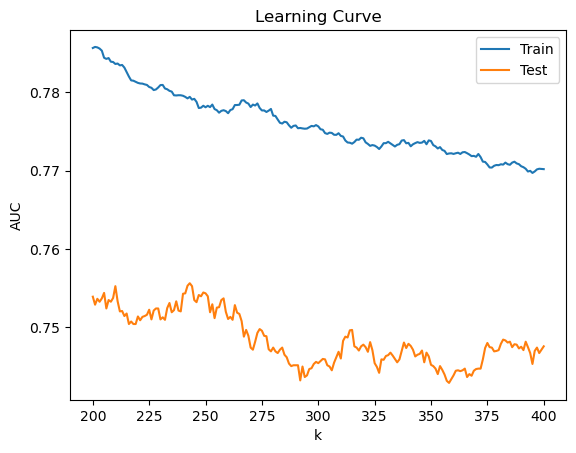

In [123]:
# Analyzing Learning Curve
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for i in param_values:
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(X_train_over, y_train_over)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train_over)
        train_auc = roc_auc_score(y_train_over, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(i) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(param_values, train_scores, label='Train')
    plt.plot(param_values, test_scores, label='Test')
    plt.xlabel('k')
    plt.ylabel('AUC')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

param_values = [int(x) for x in np.linspace(200, 400, 200)]
draw_learning_curve(param_values)

## Decision Tree

In [125]:
# Without Standardization
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_train_over, y_train_over) # fit model decision tree dari data train
eval_classification(dt, X_test, y_test)

ROC-AUC Score: 0.613

Confusion Matrix:
[[39 35]
 [38 88]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.53      0.52        74
           1       0.72      0.70      0.71       126

    accuracy                           0.64       200
   macro avg       0.61      0.61      0.61       200
weighted avg       0.64      0.64      0.64       200



In [126]:
# decision tree
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_train_over, y_train_over) # fit model decision tree dari data train
eval_classification(dt, X_test, y_test)

ROC-AUC Score: 0.622

Confusion Matrix:
[[41 33]
 [39 87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.55      0.53        74
           1       0.72      0.69      0.71       126

    accuracy                           0.64       200
   macro avg       0.62      0.62      0.62       200
weighted avg       0.65      0.64      0.64       200



In [127]:
# Standardization
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_train_under, y_train_under) # fit model decision tree dari data train
eval_classification(dt, X_test, y_test)

ROC-AUC Score: 0.587

Confusion Matrix:
[[44 30]
 [53 73]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.59      0.51        74
           1       0.71      0.58      0.64       126

    accuracy                           0.58       200
   macro avg       0.58      0.59      0.58       200
weighted avg       0.61      0.58      0.59       200



In [128]:
# decision tree
from sklearn.tree import DecisionTreeClassifier # import decision tree dari sklearn
dt = DecisionTreeClassifier() # inisiasi object dengan nama dt
dt.fit(X_train_under, y_train_under) # fit model decision tree dari data train
eval_classification(dt, X_test, y_test)

ROC-AUC Score: 0.571

Confusion Matrix:
[[41 33]
 [52 74]]

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.55      0.49        74
           1       0.69      0.59      0.64       126

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.56       200
weighted avg       0.60      0.57      0.58       200



## Bagging: RandomForest

In [130]:
# Without Standardization  

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_over, y_train_over)
eval_classification(rf, X_test, y_test)

ROC-AUC Score: 0.800

Confusion Matrix:
[[48 26]
 [30 96]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63        74
           1       0.79      0.76      0.77       126

    accuracy                           0.72       200
   macro avg       0.70      0.71      0.70       200
weighted avg       0.72      0.72      0.72       200



In [131]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_over, y_train_over)
eval_classification(rf, X_test, y_test)

ROC-AUC Score: 0.800

Confusion Matrix:
[[48 26]
 [30 96]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63        74
           1       0.79      0.76      0.77       126

    accuracy                           0.72       200
   macro avg       0.70      0.71      0.70       200
weighted avg       0.72      0.72      0.72       200



In [132]:
# Standardization

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_under, y_train_under)
eval_classification(rf, X_test, y_test)

ROC-AUC Score: 0.782

Confusion Matrix:
[[56 18]
 [44 82]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.76      0.64        74
           1       0.82      0.65      0.73       126

    accuracy                           0.69       200
   macro avg       0.69      0.70      0.68       200
weighted avg       0.72      0.69      0.70       200



In [133]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_under, y_train_under)
eval_classification(rf, X_test, y_test)

ROC-AUC Score: 0.782

Confusion Matrix:
[[56 18]
 [44 82]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.76      0.64        74
           1       0.82      0.65      0.73       126

    accuracy                           0.69       200
   macro avg       0.69      0.70      0.68       200
weighted avg       0.72      0.69      0.70       200



## Boosting: Adaboost

In [135]:
# Standardization
clf = AdaBoostClassifier()
clf.fit(X_train_over, y_train_over)
eval_classification(clf, X_test, y_test)

ROC-AUC Score: 0.802

Confusion Matrix:
[[50 24]
 [36 90]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.68      0.62        74
           1       0.79      0.71      0.75       126

    accuracy                           0.70       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.71      0.70      0.70       200



In [136]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(X_train_over, y_train_over)
eval_classification(clf, X_test, y_test)

ROC-AUC Score: 0.802

Confusion Matrix:
[[50 24]
 [36 90]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.68      0.62        74
           1       0.79      0.71      0.75       126

    accuracy                           0.70       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.71      0.70      0.70       200



In [137]:
# Standardization
clf = AdaBoostClassifier()
clf.fit(X_train_under, y_train_under)
eval_classification(clf, X_test, y_test)

ROC-AUC Score: 0.786

Confusion Matrix:
[[56 18]
 [40 86]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.76      0.66        74
           1       0.83      0.68      0.75       126

    accuracy                           0.71       200
   macro avg       0.71      0.72      0.70       200
weighted avg       0.74      0.71      0.71       200



In [138]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(X_train_under, y_train_under)
eval_classification(clf, X_test, y_test)

ROC-AUC Score: 0.786

Confusion Matrix:
[[56 18]
 [40 86]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.76      0.66        74
           1       0.83      0.68      0.75       126

    accuracy                           0.71       200
   macro avg       0.71      0.72      0.70       200
weighted avg       0.74      0.71      0.71       200



## Boosting: XGBoost

In [140]:
# Standardization
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(X_train_over, y_train_over)
eval_classification(xg, X_test, y_test)

ROC-AUC Score: 0.786

Confusion Matrix:
[[ 44  30]
 [ 25 101]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.59      0.62        74
           1       0.77      0.80      0.79       126

    accuracy                           0.72       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.72      0.72      0.72       200



In [141]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=42)
# rs = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
gs = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42, scoring='recall')
gs.fit(X_train,y_train)

# Predict & Evaluation
eval_classification(gs, X_test, y_test)

ROC-AUC Score: 0.805

Confusion Matrix:
[[ 39  35]
 [ 18 108]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.53      0.60        74
           1       0.76      0.86      0.80       126

    accuracy                           0.73       200
   macro avg       0.72      0.69      0.70       200
weighted avg       0.73      0.73      0.73       200



In [142]:
# Standardization

xg = XGBClassifier()
xg.fit(X_train_under, y_train_under)
eval_classification(xg, X_test, y_test)

ROC-AUC Score: 0.781

Confusion Matrix:
[[54 20]
 [35 91]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.73      0.66        74
           1       0.82      0.72      0.77       126

    accuracy                           0.72       200
   macro avg       0.71      0.73      0.72       200
weighted avg       0.74      0.72      0.73       200



# Model Evaluation

In [144]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score


In [145]:
#evaluation of results
def model_evaluation(y_test, y_pred, y_pred_proba, model_name):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])  # FIXED

    print(f"\n📊 {model_name} Performance")
    print(f"Accuracy     : {acc:.3f}")
    print(f"Precision    : {prec:.3f}")
    print(f"Recall       : {rec:.3f}")
    print(f"ROC-AUC Score: {auc:.3f}")

    return {
        "model": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "roc_auc": auc
    }


In [146]:
# Logistic regression
classifier1 = LogisticRegression()
classifier1.fit(X_train_over, y_train_over)
y_pred1 = classifier1.predict(X_test)
y_pred_proba1 = classifier1.predict_proba(X_test)

#knn
classifier2 = KNeighborsClassifier(n_neighbors=22, metric="minkowski", p=2)
classifier2.fit(X_train_over, y_train_over)
y_pred2 = classifier2.predict(X_test)
y_pred_proba2 = classifier2.predict_proba(X_test)

#Decision tree
classifier3 = DecisionTreeClassifier(criterion="entropy", random_state=0)
classifier3.fit(X_train, y_train)
y_pred3 = classifier3.predict(X_test)
y_pred_proba3 = classifier3.predict_proba(X_test)

#Random Forest
classifier4 = RandomForestClassifier(n_estimators=72, criterion="entropy", random_state=0)
classifier4.fit(X_train_over, y_train_over)
y_pred4 = classifier4.predict(X_test)
y_pred_proba4 = classifier4.predict_proba(X_test)

#Adaboost
classifier5 = AdaBoostClassifier()
classifier5.fit(X_train_over, y_train_over)
y_pred5 = classifier5.predict(X_test)
y_pred_proba5 = classifier5.predict_proba(X_test)

#XGBoost
classifier6 = XGBClassifier()
classifier6.fit(X_train_over, y_train_over)
y_pred6 = classifier6.predict(X_test)
y_pred_proba6 = classifier6.predict_proba(X_test)

In [147]:
# standardization
logreg = LogisticRegression() # inisiasi object dengan nama logreg
logreg.fit(X_train_over, y_train_over) # fit model classification dari data train
roc_auc_score(y_test, y_pred1)

0.6735306735306735

In [148]:
lr = model_evaluation(y_test, y_pred1, y_pred_proba1, "Logistic Regression")
knn = model_evaluation(y_test, y_pred2, y_pred_proba2, "K-Nearest Neighbours")
dt = model_evaluation(y_test, y_pred3, y_pred_proba3, "Decision Tree")
rf = model_evaluation(y_test, y_pred4, y_pred_proba4, "Random Forest")
ab = model_evaluation(y_test, y_pred5, y_pred_proba5, "Adaboost")
xg = model_evaluation(y_test, y_pred6, y_pred_proba6, "XGBoost")


📊 Logistic Regression Performance
Accuracy     : 0.680
Precision    : 0.772
Recall       : 0.698
ROC-AUC Score: 0.758

📊 K-Nearest Neighbours Performance
Accuracy     : 0.625
Precision    : 0.815
Recall       : 0.524
ROC-AUC Score: 0.745

📊 Decision Tree Performance
Accuracy     : 0.740
Precision    : 0.789
Recall       : 0.802
ROC-AUC Score: 0.718

📊 Random Forest Performance
Accuracy     : 0.715
Precision    : 0.800
Recall       : 0.730
ROC-AUC Score: 0.808

📊 Adaboost Performance
Accuracy     : 0.700
Precision    : 0.789
Recall       : 0.714
ROC-AUC Score: 0.802

📊 XGBoost Performance
Accuracy     : 0.725
Precision    : 0.771
Recall       : 0.802
ROC-AUC Score: 0.786


In [149]:
# Gabungkan semua hasil evaluasi ke dalam list
results = [lr, knn, dt, rf, ab, xg]

# Ubah menjadi DataFrame
eval_ = pd.DataFrame(results)

# Sort berdasarkan roc_auc, recall, dll (pastikan key-nya sesuai isi dict-mu)
eval_ = eval_.sort_values(by=["roc_auc", "recall"], ascending=False).reset_index(drop=True)

# Tampilkan
eval_

,model,accuracy,precision,recall,roc_auc
0,Random Forest,0.715,0.800000,0.730159,0.808344
1,Adaboost,0.700,0.789474,0.714286,0.802338
2,XGBoost,0.725,0.770992,0.801587,0.786465
3,Logistic Regression,0.680,0.771930,0.698413,0.758151
4,K-Nearest Neighbours,0.625,0.814815,0.523810,0.745495
5,Decision Tree,0.740,0.789062,0.801587,0.718361


## Data Test

In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score


In [152]:
def model_evaluation(y_true, y_pred, y_pred_proba, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2.0)
    auc = roc_auc_score(y_true, y_pred_proba[:, 1])

    results = pd.DataFrame([[model_name, acc, prec, rec, f1, f2, auc]],
                       columns=["Model", "Accuracy", "Precision", "Recall",
                                "F1 Score", "F2 Score", "roc_auc_score"])
    return results

# Logistic regression
classifier1 = LogisticRegression()
classifier1.fit(X_train_over, y_train_over)
y_pred1 = classifier1.predict(X_test)
y_pred_proba1 = classifier1.predict_proba(X_test)

# KNN (tuned)
classifier2 = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski', p=1)
classifier2.fit(X_train_over, y_train_over)
y_pred2 = classifier2.predict(X_test)
y_pred_proba2 = classifier2.predict_proba(X_test)

# Decision tree (tuned)
classifier3 = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=5, random_state=42)
classifier3.fit(X_train, y_train)
y_pred3 = classifier3.predict(X_test)
y_pred_proba3 = classifier3.predict_proba(X_test)

# Random Forest (tuned)
classifier4 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
classifier4.fit(X_train_over, y_train_over)
y_pred4 = classifier4.predict(X_test)
y_pred_proba4 = classifier4.predict_proba(X_test)

# Adaboost (tuned)
classifier5 = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
classifier5.fit(X_train_over, y_train_over)
y_pred5 = classifier5.predict(X_test)
y_pred_proba5 = classifier5.predict_proba(X_test)

# XGBoost (tuned)
classifier6 = XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=200, subsample=0.8, colsample_bytree=0.8, random_state=42)
classifier6.fit(X_train_over, y_train_over)
y_pred6 = classifier6.predict(X_test)
y_pred_proba6 = classifier6.predict_proba(X_test)

# Evaluate on test data
lr = model_evaluation(y_test, y_pred1, y_pred_proba1, "Logistic Regression")
knn = model_evaluation(y_test, y_pred2, y_pred_proba2, "K-Nearest Neighbours")
dt = model_evaluation(y_test, y_pred3, y_pred_proba3, "Decision Tree")
rf = model_evaluation(y_test, y_pred4, y_pred_proba4, "Random Forest")
ab = model_evaluation(y_test, y_pred5, y_pred_proba5, "Adaboost")
xg = model_evaluation(y_test, y_pred6, y_pred_proba6, "XGBoost")

eval_test_tuned = pd.concat([lr, knn, dt, rf, ab, xg], ignore_index=True)
eval_test_tuned = eval_test_tuned.sort_values(["roc_auc_score", "Recall", "F2 Score"],
                                  ascending=False).reset_index(drop=True)

# Ensure column order matches the previous output
column_order = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "F2 Score", "roc_auc_score"]
eval_test_tuned = eval_test_tuned[column_order]

eval_test_tuned

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,roc_auc_score
0,Adaboost,0.690,0.796296,0.682540,0.735043,0.702614,0.823091
1,Random Forest,0.720,0.796610,0.746032,0.770492,0.755627,0.805556
2,XGBoost,0.695,0.755906,0.761905,0.758893,0.760697,0.788181
3,Decision Tree,0.750,0.801587,0.801587,0.801587,0.801587,0.760618
4,Logistic Regression,0.680,0.771930,0.698413,0.733333,0.711974,0.758151
5,K-Nearest Neighbours,0.660,0.778846,0.642857,0.704348,0.666118,0.711819


## Data Train

In [154]:
def model_evaluation(y_true, y_pred, y_pred_proba, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2.0)
    auc = roc_auc_score(y_true, y_pred_proba[:, 1])

    results = pd.DataFrame([[model_name, acc, prec, rec, f1, f2, auc]],
                       columns=["Model", "Accuracy", "Precision", "Recall",
                                "F1 Score", "F2 Score", "roc_auc_score"])
    return results

# Logistic regression (tuned)
classifier1 = LogisticRegression()
classifier1.fit(X_train_over, y_train_over)
y_pred1 = classifier1.predict(X_train_over)
y_pred_proba1 = classifier1.predict_proba(X_train_over)

# KNN (tuned)
classifier2 = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski', p=1)
classifier2.fit(X_train_over, y_train_over)
y_pred2 = classifier2.predict(X_train_over)
y_pred_proba2 = classifier2.predict_proba(X_train_over)

# Decision tree (tuned)
classifier3 = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=5, random_state=42)
classifier3.fit(X_train, y_train)
y_pred3 = classifier3.predict(X_train)
y_pred_proba3 = classifier3.predict_proba(X_train)

# Random Forest (tuned)
classifier4 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
classifier4.fit(X_train_over, y_train_over)
y_pred4 = classifier4.predict(X_train_over)
y_pred_proba4 = classifier4.predict_proba(X_train_over)

# Adaboost (tuned)
classifier5 = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
classifier5.fit(X_train_over, y_train_over)
y_pred5 = classifier5.predict(X_train_over)
y_pred_proba5 = classifier5.predict_proba(X_train_over)

# XGBoost (tuned)
classifier6 = XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=200, subsample=0.8, colsample_bytree=0.8, random_state=42)
classifier6.fit(X_train_over, y_train_over)
y_pred6 = classifier6.predict(X_train_over)
y_pred_proba6 = classifier6.predict_proba(X_train_over)

# Evaluate on training data
lr = model_evaluation(y_train_over, y_pred1, y_pred_proba1, "Logistic Regression")
knn = model_evaluation(y_train_over, y_pred2, y_pred_proba2, "K-Nearest Neighbours")
dt = model_evaluation(y_train, y_pred3, y_pred_proba3, "Decision Tree")
rf = model_evaluation(y_train_over, y_pred4, y_pred_proba4, "Random Forest")
ab = model_evaluation(y_train_over, y_pred5, y_pred_proba5, "Adaboost")
xg = model_evaluation(y_train_over, y_pred6, y_pred_proba6, "XGBoost")

eval_train_tuned = pd.concat([lr, knn, dt, rf, ab, xg], ignore_index=True)
eval_train_tuned = eval_train_tuned.sort_values(["roc_auc_score", "Recall", "F2 Score"],
                                    ascending=False).reset_index(drop=True)

# Ensure column order matches the test data output
column_order = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "F2 Score", "roc_auc_score"]
eval_train_tuned = eval_train_tuned[column_order]

eval_train_tuned

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,roc_auc_score
0,K-Nearest Neighbours,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,Random Forest,0.991054,0.994000,0.988072,0.991027,0.989252,0.999862
3,Decision Tree,0.900000,0.927273,0.912525,0.919840,0.915437,0.973519
4,Adaboost,0.778330,0.777778,0.779324,0.778550,0.779014,0.878218
5,Logistic Regression,0.746521,0.752033,0.735586,0.743719,0.738818,0.828101


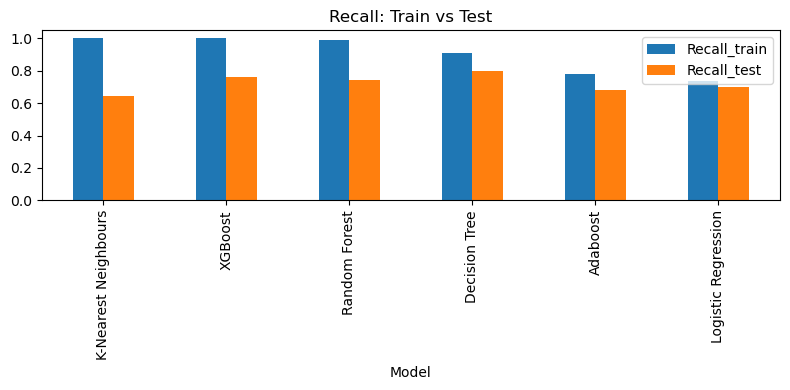

In [155]:
# ===== Visual compare Recall & AUC on Train vs Test =====
merged = eval_train_tuned.merge(eval_test_tuned, on='Model', suffixes=('_train','_test'))
merged.plot(x='Model', y=['Recall_train','Recall_test'], kind='bar', figsize=(8,4))
plt.title('Recall: Train vs Test'); plt.tight_layout()


In [156]:
predictions = [y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6]

for i, j in zip(predictions, eval_test_tuned["Model"].values):
    print(f"Checking: {j}, len(y_test)={len(y_test)}, len(prediction)={len(i)}")
    if len(i) != len(y_test):
        print(f"Skip model {j} karena jumlah sample tidak sesuai.")
        continue
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_test, i),
                annot=True, fmt="d", linecolor="k", linewidths=3)
    plt.title(j, fontsize=14)
    plt.show()


Checking: Adaboost, len(y_test)=200, len(prediction)=1006
Skip model Adaboost karena jumlah sample tidak sesuai.
Checking: Random Forest, len(y_test)=200, len(prediction)=1006
Skip model Random Forest karena jumlah sample tidak sesuai.
Checking: XGBoost, len(y_test)=200, len(prediction)=800
Skip model XGBoost karena jumlah sample tidak sesuai.
Checking: Decision Tree, len(y_test)=200, len(prediction)=1006
Skip model Decision Tree karena jumlah sample tidak sesuai.
Checking: Logistic Regression, len(y_test)=200, len(prediction)=1006
Skip model Logistic Regression karena jumlah sample tidak sesuai.
Checking: K-Nearest Neighbours, len(y_test)=200, len(prediction)=1006
Skip model K-Nearest Neighbours karena jumlah sample tidak sesuai.


In [157]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

vote_model = VotingClassifier(
    estimators = [
        ('lr', LogisticRegression()),
        ('knn', KNeighborsClassifier(n_neighbors=22, metric="minkowski", p=2)),
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
        ('ab', AdaBoostClassifier()),
        ('xg', XGBClassifier()),
    ], voting = 'soft')

vote_model.fit(X_train, y_train)
eval_classification(vote_model, X_test, y_test)

ROC-AUC Score: 0.788

Confusion Matrix:
[[ 41  33]
 [ 23 103]]

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.55      0.59        74
           1       0.76      0.82      0.79       126

    accuracy                           0.72       200
   macro avg       0.70      0.69      0.69       200
weighted avg       0.71      0.72      0.72       200



# SHAP

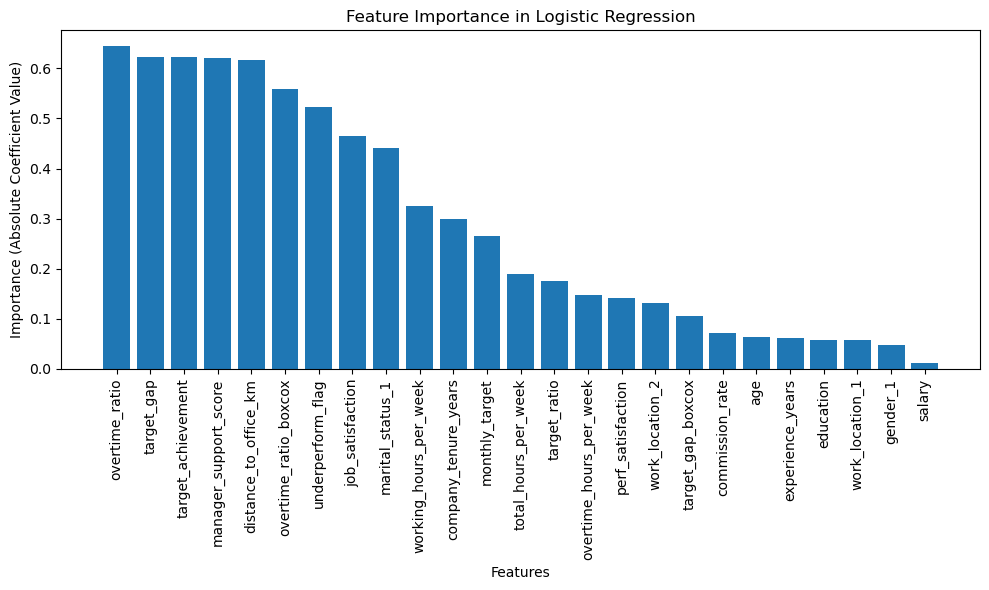

                    feature  importance
0            overtime_ratio    0.643859
1                target_gap    0.623342
2        target_achievement    0.623342
3     manager_support_score    0.619808
4     distance_to_office_km    0.616477
5     overtime_ratio_boxcox    0.558891
6         underperform_flag    0.522826
7          job_satisfaction    0.465379
8          marital_status_1    0.440726
9    working_hours_per_week    0.326049
10     company_tenure_years    0.299077
11           monthly_target    0.264618
12     total_hours_per_week    0.188561
13             target_ratio    0.176040
14  overtime_hours_per_week    0.147047
15        perf_satisfaction    0.142029
16          work_location_2    0.130921
17        target_gap_boxcox    0.105935
18          commission_rate    0.072306
19                      age    0.064585
20         experience_years    0.061287
21                education    0.058247
22          work_location_1    0.056979
23                 gender_1    0.046834


In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asumsikan 'logreg' adalah model logistic regression yang sudah dilatih
# dan 'X' adalah DataFrame yang berisi fitur-fitur

# Mendapatkan nama fitur
feature_names = X.columns

# Mendapatkan koefisien absolut
coefficients = np.abs(logreg.coef_[0])

# Membuat DataFrame untuk feature importance
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': coefficients})

# Mengurutkan berdasarkan importance
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

# Visualisasi
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance (Absolute Coefficient Value)')
plt.title('Feature Importance in Logistic Regression')
plt.tight_layout()
plt.show()

# Mencetak feature importance
print(feature_importance)

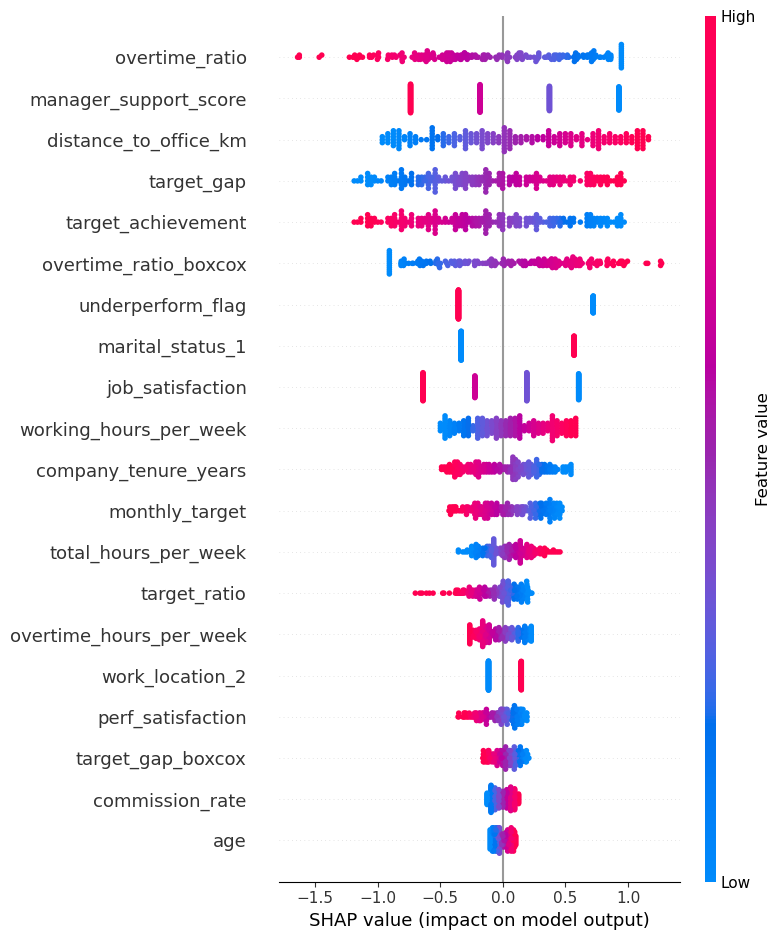

In [160]:
import shap
explainer = shap.LinearExplainer(logreg, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test) # Summary shap value terhadap label positive

In [161]:
# Force Plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0,:])

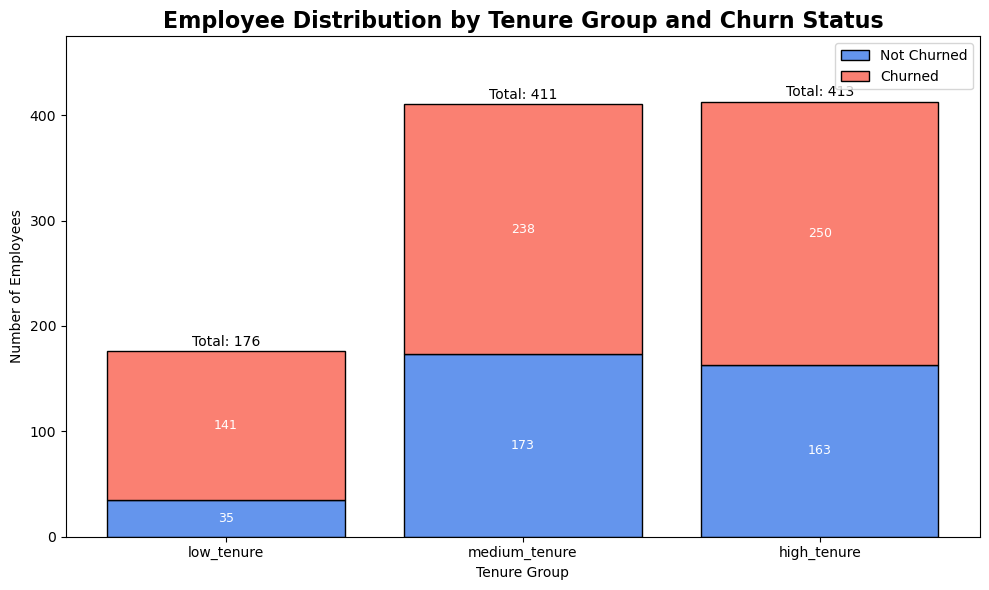

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ─── 1. Baca data
df = pd.read_csv("employee_churn_prediction_updated.csv")

# (opsional) hapus kolom churn_period yang dianggap leakage
df = df.drop(columns=[c for c in df.columns if c.startswith("churn_period")], errors="ignore")

# ─── 2. Buat kelompok tenure
#    di sini contoh 3 bucket: 0‑1 thn, 1‑3 thn, >3 thn
df["tenure_group"] = pd.cut(
    df["company_tenure_years"],
    bins=[-np.inf, 1, 3, np.inf],
    labels=["low_tenure", "medium_tenure", "high_tenure"],
    include_lowest=True
)

# ─── 3. Hitung jumlah karyawan churn / tidak churn per kelompok
# pakai employee_id hanya untuk .count(); bisa diganti any column
agg = (
    df.groupby(["tenure_group", "churn"])["employee_id"]
      .count()
      .unstack(fill_value=0)
      .rename(columns={0: "Not Churned", 1: "Churned"})
      .reset_index()
)

# ─── 4. Siapkan data plot
x             = agg["tenure_group"]
y_not_churned = agg["Not Churned"]
y_churned     = agg["Churned"]

# ─── 5. Plot stacked bar
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, y_not_churned, label="Not Churned", color="cornflowerblue", edgecolor="black")
ax.bar(x, y_churned,     bottom=y_not_churned, label="Churned",     color="salmon",       edgecolor="black")

ax.set_title("Employee Distribution by Tenure Group and Churn Status", fontsize=16, fontweight="bold")
ax.set_xlabel("Tenure Group")
ax.set_ylabel("Number of Employees")
ax.legend()

# label di atas bar
for i, (nc, c) in enumerate(zip(y_not_churned, y_churned)):
    total = nc + c
    ax.text(i, total + 2,      f"Total: {total}",      ha="center", va="bottom", fontsize=10)
    ax.text(i, nc/2,           f"{nc}",                ha="center", va="center", color="white", fontsize=9)
    if c > 0:
        ax.text(i, nc + c/2,   f"{c}",                 ha="center", va="center", color="white", fontsize=9)

ax.set_ylim(0, (y_not_churned + y_churned).max() * 1.15)
plt.tight_layout()
plt.show()
